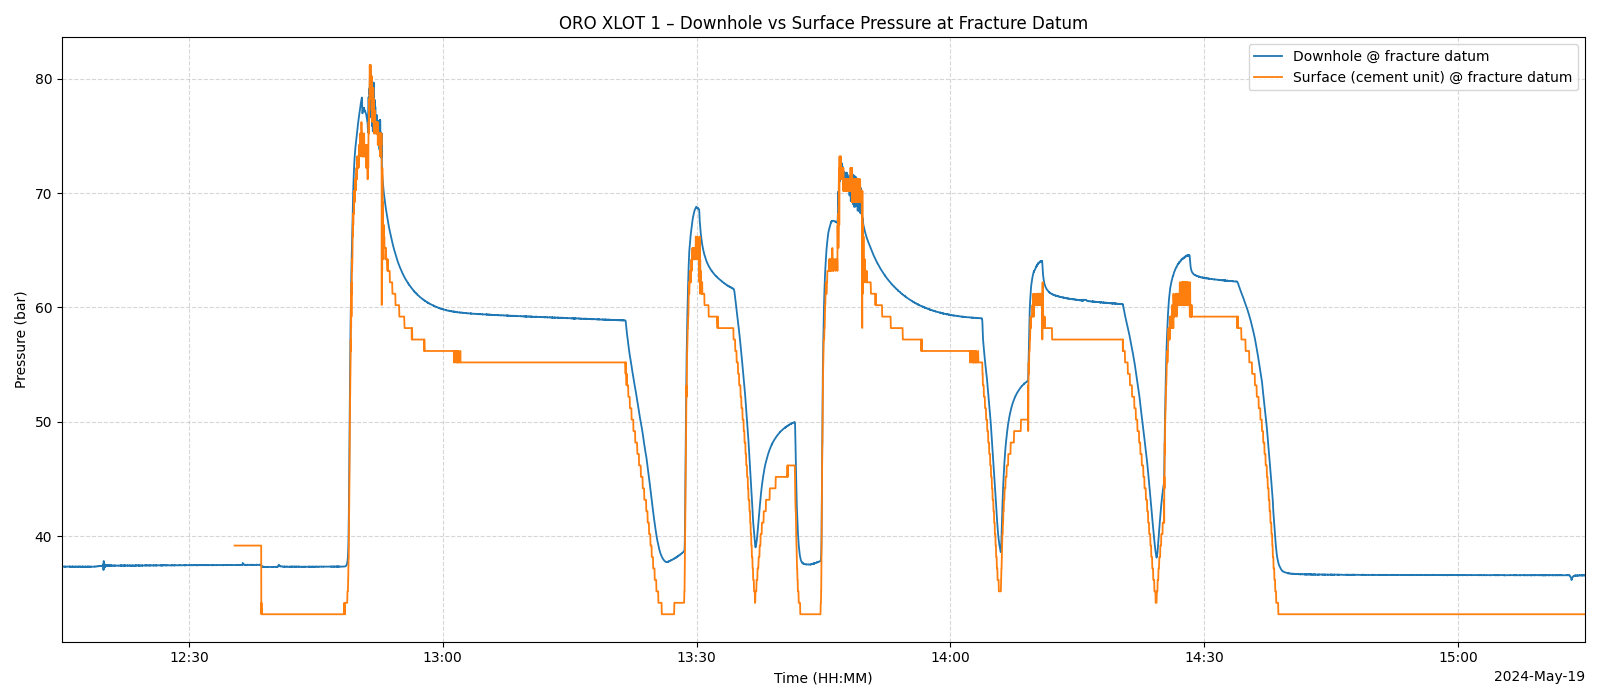

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# --- Standard library ---
import re
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from statistics import mode, StatisticsError
from typing import Optional, List, Dict, Any, Tuple

# --- Third-party scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

%matplotlib widget

# ------------------------------ Config ------------------------------
base = Path("Data")

DOWNHOLE_FILE = base / "XLOT_minifrac/Oranjeoord/ORO-01_XLOT1_and_XLOT2_DownholeGauge_10samplesperS_DC8907.txt"
CEMENT_FILE   = base / "XLOT_minifrac/Oranjeoord/ORO_01_Xlot2_Cementing_Unit_data.txt"

SHIFT_HOURS   = -1.04 - 0.000556   # ~5 s

# Time window
START_D = pd.to_datetime("2024-05-19 12:15:00")
END_D   = pd.to_datetime("2024-05-19 15:15:00")

NAME = "ORO"
TEST_NO = "1"

# (A) Geometry / sensor positions
MD = np.array([336.6, 336.6, 356.6], dtype=float)
TVD = np.array([330.1, 330.1, 350.1], dtype=float)
TVD_fracture_m = 341.5
gauge_index    = 1
TVD_surface_sensor_m = -0.3

# (C) Unit constants
PSIA_TO_BAR = 1.0 / 14.5037738
RHO = 1080      # fallback density
G   = 9.80665
PA_TO_BAR = 1e-5


# ------------------------------ Utilities ------------------------------
def estimate_lag(MD, TVD, gauge_index, TVD_fracture_m):
    MD = np.asarray(MD, float)
    TVD = np.asarray(TVD, float)

    TVD_interp = np.interp(MD, MD[~np.isnan(TVD)], TVD[~np.isnan(TVD)])
    TVD_gauge_m = float(TVD_interp[gauge_index])

    return TVD_interp, TVD_gauge_m, float(TVD_fracture_m) - TVD_gauge_m


def _parse_start_datetime_from_tool_file(path: Path) -> Optional[pd.Timestamp]:
    """
    For DC8907-style downhole files with:
        Serial Number of Tool: ...
        Start Date: 16/05/2024   (dd/MM/yyyy)
        Start Time: 15:31:00     (HH:mm:ss 24-hour)
    """
    start_date = None
    start_time = None

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if s.startswith("Start Date:"):
                # expect pieces like ['Start', 'Date:', '16/05/2024', '(dd/MM/yyyy)']
                parts = re.split(r"\s+", s)
                for token in parts:
                    if re.match(r"\d{2}/\d{2}/\d{4}", token):
                        start_date = token
                        break
            elif s.startswith("Start Time:"):
                # expect ['Start', 'Time:', '15:31:00', '(HH:mm:ss', '24-hour)']
                parts = re.split(r"\s+", s)
                for token in parts:
                    if re.match(r"\d{2}:\d{2}:\d{2}", token):
                        start_time = token
                        break

    if start_date and start_time:
        return pd.to_datetime(
            f"{start_date} {start_time}",
            format="%d/%m/%Y %H:%M:%S",
            errors="coerce",
        )
    return None


# ------------------------------ Downhole loader ------------------------------
def load_downhole_heesch(path: Path) -> pd.DataFrame:
    """
    Robust loader for Heesch downhole data.

    Supports:
    (1) NLOG 'with time' format:

        Time    Elapsed Time   Pressure    Temperature
        (mm:dd:yyyy:hh:mm:ss)  (hours)     (psia)      (degC)
        12:24:2024:03:53:01    0.000278    10.411      22.463
        ...

    (2) DC8907 'elapsed only' format:

        Serial Number of Tool: DC8907
        Start Date: 16/05/2024  (dd/MM/yyyy)
        Start Time: 15:31:00    (HH:mm:ss 24-hour)
        ...
        Elapsed Time  Pressure  Temperature
        (hours)       (psia)    (degC)
        0.000278      10.132    23.251
        ...
    """
    header_time = None
    header_elapsed_only = None

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            s = line.strip()
            if s.startswith("Time\tElapsed Time\tPressure"):
                header_time = i
                break
            if s.startswith("Elapsed Time") and "Pressure" in s and "\t" in s:
                header_elapsed_only = i
                # do not break; keep scanning in case there's also a Time header
                # but usually there won't be

    if header_time is not None:
        # Format (1): has absolute Time column
        df = pd.read_csv(
            path,
            sep=r"\t+",
            engine="python",
            header=header_time,
            on_bad_lines="skip",
        )

        t = pd.to_datetime(
            df.iloc[:, 0].astype(str).str.strip(),
            format="%m:%d:%Y:%H:%M:%S",
            errors="coerce",
        )
        pressure = pd.to_numeric(df.iloc[:, 2], errors="coerce")

        T_degC = None
        if df.shape[1] > 3:
            T_degC = pd.to_numeric(df.iloc[:, 3], errors="coerce")

    elif header_elapsed_only is not None:
        # Format (2): elapsed time only, use Start Date + Start Time
        base_t = _parse_start_datetime_from_tool_file(path)
        if base_t is None:
            raise RuntimeError("Could not parse Start Date/Time from downhole file.")

        # header_elapsed_only line = 'Elapsed Time\tPressure\tTemperature'
        # next line = '(hours)\t(psia)\t(degC)' -> use that as header row
        df = pd.read_csv(
            path,
            sep=r"\t+",
            engine="python",
            header=header_elapsed_only + 1,
            on_bad_lines="skip",
        )

        # first column = elapsed time in hours
        elapsed_hours = pd.to_numeric(df.iloc[:, 0], errors="coerce")
        t = base_t + pd.to_timedelta(elapsed_hours, unit="h")
        pressure = pd.to_numeric(df.iloc[:, 1], errors="coerce")

        T_degC = None
        if df.shape[1] > 2:
            T_degC = pd.to_numeric(df.iloc[:, 2], errors="coerce")

    else:
        raise RuntimeError("Could not locate downhole data header in file.")

    out = pd.DataFrame({"time": t, "pressure_psia": pressure})
    if T_degC is not None:
        out["T_degC"] = T_degC

    return (
        out.dropna(subset=["time"])
           .sort_values("time")
           .drop_duplicates(subset=["time"])
           .set_index("time")
    )


# ------------------------------ Cement-unit loader ------------------------------
def load_cement_heesch(path: Path) -> pd.DataFrame:
    """
    For surface cement-unit file like:

    Time    CMT RATE    CMT VOL    CMT TREAT PRES    PUMP PRESSURE    CMT RATE RETURN    RETURNNRD
    mm:dd:yyyy:hh:mm:ss l/min      L          bars   bars             l/min              L
    ____  ________  ...   (underscore row)
    05:18:2024:17:52:56  0,00      0,00       0,00   0,25             0,000              0,000
    ...
    """
    df = pd.read_csv(
        path, sep=r"\t+", engine="python", header=0, on_bad_lines="skip"
    )

    # Drop the units row and the '____' row
    time_str = df["Time"].astype(str)
    mask_valid = ~time_str.str.contains("mm:dd:yyyy", na=False) & \
                 ~time_str.str.contains("_", na=False)
    df = df[mask_valid].copy()

    # Parse time
    t = pd.to_datetime(
        df["Time"].astype(str).str.strip(),
        format="%m:%d:%Y:%H:%M:%S",
        errors="coerce",
    )

    def num_from_col(colname: str):
        if colname not in df.columns:
            return None
        # handle comma as decimal separator: "0,25" -> "0.25"
        s = df[colname].astype(str).str.replace(",", ".", regex=False)
        return pd.to_numeric(s, errors="coerce")

    flow_in   = num_from_col("CMT RATE")
    flow_ret  = num_from_col("CMT RATE RETURN")
    treat_bar = num_from_col("CMT TREAT PRES")
    density   = num_from_col("CMT DENSITY")  # may be None for this file

    out = pd.DataFrame({"time": t})

    if flow_in is not None:
        out["flow_lpm"] = flow_in
    if flow_ret is not None:
        out["flow_return_lpm"] = flow_ret
    if treat_bar is not None:
        out["treating_pressure_bar"] = treat_bar
    if density is not None:
        out["density_kgm3"] = density

    return (
        out.dropna(subset=["time"])
           .sort_values("time")
           .drop_duplicates(subset=["time"])
           .set_index("time")
    )


# ------------------------------ Load data ------------------------------
dh_df = load_downhole_heesch(DOWNHOLE_FILE).loc[START_D:END_D]
cm_df = load_cement_heesch(CEMENT_FILE)

# Shift ALL surface columns together in time
if SHIFT_HOURS != 0:
    cm_df.index = cm_df.index - pd.to_timedelta(SHIFT_HOURS, unit="h")

cm_df = cm_df.loc[START_D:END_D]
cm_df = cm_df.groupby(cm_df.index).mean(numeric_only=True)

# ------------------------------ Regular grid ------------------------------
full_index = pd.date_range(START_D, END_D, freq="0.1s")

dh_full = dh_df.reindex(full_index).interpolate("time")
cm_full = (
    cm_df
    .reindex(full_index.union(cm_df.index))
    .interpolate("time")
    .reindex(full_index)
)

# ------------------------------ Merge ------------------------------
combined = pd.concat(
    [
        dh_full[["pressure_psia"]],
        dh_full.get("T_degC"),
        cm_full.get("flow_lpm"),
        cm_full.get("flow_return_lpm"),
        cm_full.get("treating_pressure_bar"),
        cm_full.get("density_kgm3"),
    ],
    axis=1,
)

# ------------------------------ Cumulative pumped / return volumes ------------------------------
dt_s = 0.1  # seconds (we're on a 1 s regular grid)

if "flow_lpm" in combined.columns:
    q_in_m3s = combined["flow_lpm"].fillna(0.0) / 60.0 / 1000.0   # L/min -> m³/s
    combined["pumped_vol_m3"] = (q_in_m3s * dt_s).cumsum()

if "flow_return_lpm" in combined.columns:
    q_ret_m3s = combined["flow_return_lpm"].fillna(0.0) / 60.0 / 1000.0
    combined["return_vol_m3"] = (q_ret_m3s * dt_s).cumsum()

# ------------------------------ Hydrostatic correction ------------------------------
combined["pressure_bar"] = combined["pressure_psia"] * PSIA_TO_BAR

# Use measured density when available; fallback to constant RHO
if "density_kgm3" in combined.columns:
    combined["density_eff"] = combined["density_kgm3"].fillna(RHO)
else:
    combined["density_eff"] = RHO

TVD_interp, TVD_gauge_m, Δg = estimate_lag(MD, TVD, gauge_index, TVD_fracture_m)
Δs = TVD_fracture_m - TVD_surface_sensor_m

combined["P_dh_at_frac_bar"] = (
    combined["pressure_bar"]
    + combined["density_eff"] * G * Δg * PA_TO_BAR
)

combined["P_surf_at_frac_bar"] = (
    combined["treating_pressure_bar"]
    + combined["density_eff"] * G * Δs * PA_TO_BAR
)

# ------------------------------ Plot ------------------------------
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(
    combined.index,
    combined["P_dh_at_frac_bar"],
    label="Downhole @ fracture datum",
    lw=1.3,
)

ax.plot(
    combined.index,
    combined["P_surf_at_frac_bar"],
    label="Surface (cement unit) @ fracture datum",
    lw=1.3,
)

ax.set_xlabel("Time (HH:MM)")
ax.set_ylabel("Pressure (bar)")
ax.set_title(f"{NAME} XLOT {TEST_NO} – Downhole vs Surface Pressure at Fracture Datum")

xloc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(xloc))

ax.grid(True, linestyle="--", alpha=0.5)
ax.set_xlim(START_D, END_D)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
# How many points per second?
dt = np.diff(combined.index.to_numpy())
print("Unique Δt:", np.unique(dt))

print("Inferred frequency:", pd.infer_freq(combined.index))
print("Sample count:", len(combined))
print("Duration [s]:", (combined.index[-1] - combined.index[0]).total_seconds())
print("Samples per second:", len(combined) / ( (combined.index[-1] - combined.index[0]).total_seconds() ))

Unique Δt: [100000000]
Inferred frequency: 100ms
Sample count: 108001
Duration [s]: 10800.0
Samples per second: 10.000092592592592


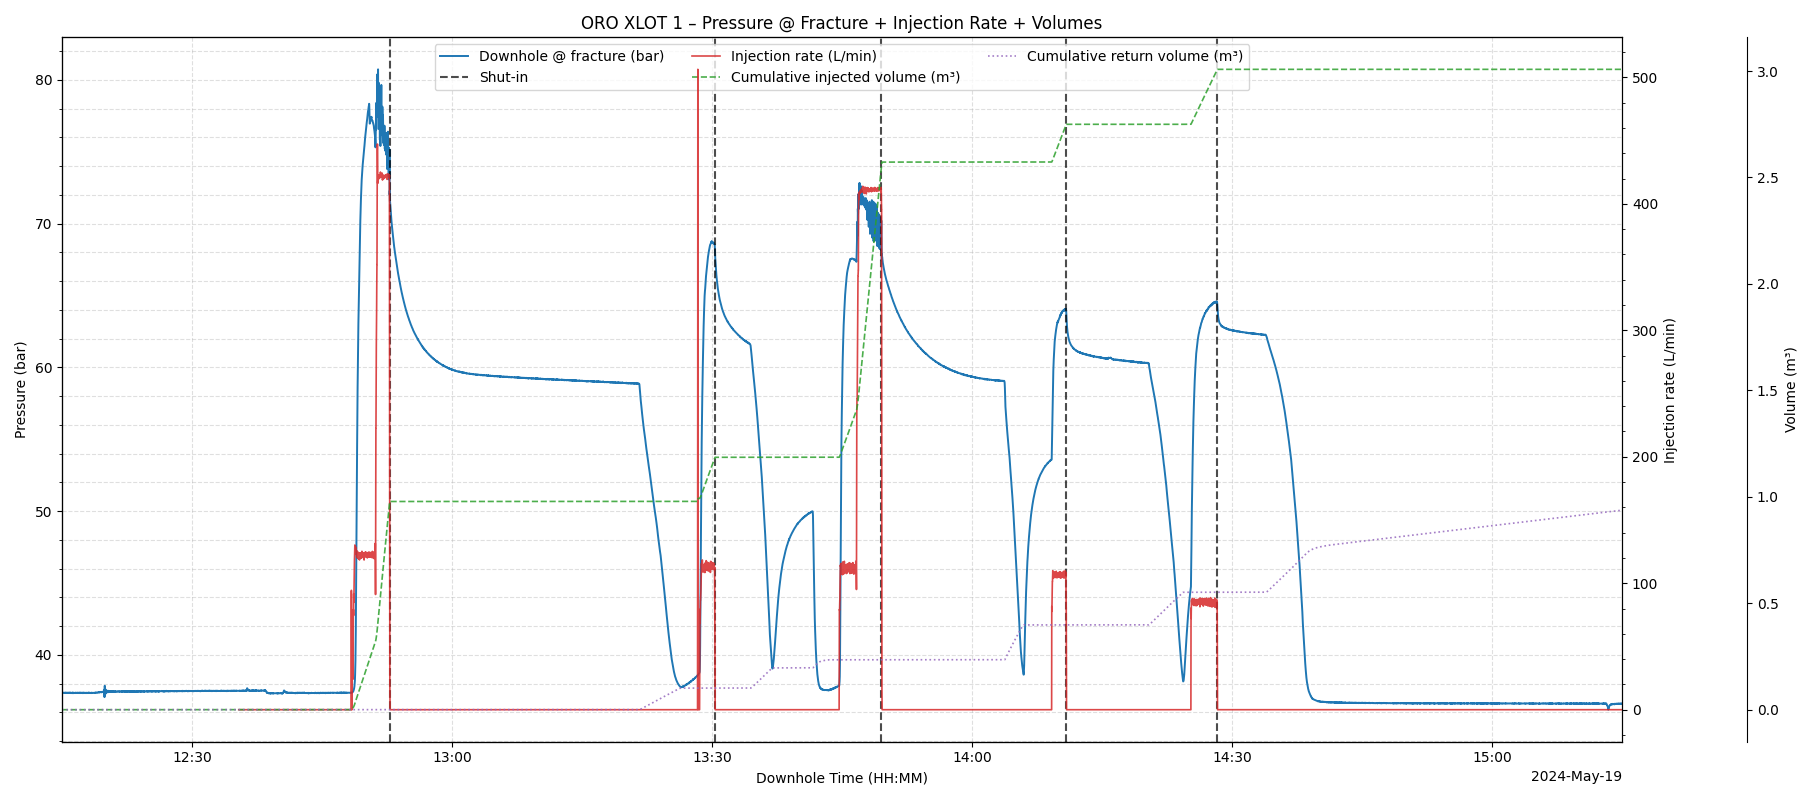

In [23]:
# ------------------------------ Cycle definitions ------------------------------
CYCLES = [
    {
        "t_start":  pd.Timestamp("2024-05-19 12:48:40"),
        "t_shutin": pd.Timestamp("2024-05-19 12:52:48"),
        "t_end":    pd.Timestamp("2024-05-19 13:21:30"),
    },
    {
        "t_start":  pd.Timestamp("2024-05-19 13:28:35"),
        "t_shutin": pd.Timestamp("2024-05-19 13:30:19"),
        "t_end":    pd.Timestamp("2024-05-19 13:34:20"),
    },
    {
        "t_start":  pd.Timestamp("2024-05-19 13:44:42"),
        "t_shutin": pd.Timestamp("2024-05-19 13:49:33"),
        "t_end":    pd.Timestamp("2024-05-19 14:03:40"),
    },
    {
        "t_start":  pd.Timestamp("2024-05-19 14:09:11"),
        "t_shutin": pd.Timestamp("2024-05-19 14:10:51"),
        "t_end":    pd.Timestamp("2024-05-19 14:20:00"),
    },
    {
        "t_start":  pd.Timestamp("2024-05-19 14:25:16"),
        "t_shutin": pd.Timestamp("2024-05-19 14:28:16"),
        "t_end":    pd.Timestamp("2024-05-19 14:33:50"),
    },

]

# ----------------------------
# Plot 2: Pressure @ fracture + injection rate + cumulative volumes
# ----------------------------
fig, ax1 = plt.subplots(figsize=(18, 8))

# --- 1) Downhole pressure @ fracture (primary axis) ---
ax1.plot(
    combined.index,
    combined["P_dh_at_frac_bar"],
    label="Downhole @ fracture (bar)",
    linewidth=1.4,
    color="C0",
)

ax1.set_xlabel("Downhole Time (HH:MM)")
ax1.set_ylabel("Pressure (bar)")

# Time formatting
xloc1 = mdates.AutoDateLocator()
xfmt1 = mdates.ConciseDateFormatter(xloc1)
ax1.xaxis.set_major_locator(xloc1)
ax1.xaxis.set_major_formatter(xfmt1)

ax1.yaxis.set_major_locator(mticker.AutoLocator())
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.4)

# --- 2) Injection rate (second axis) ---
ax2 = ax1.twinx()

if "flow_lpm" in combined.columns:
    ax2.plot(
        combined.index,
        combined["flow_lpm"],
        label="Injection rate (L/min)",
        linewidth=1.2,
        color="C3",
        alpha=0.85,
    )

ax2.set_ylabel("Injection rate (L/min)")
ax2.yaxis.set_major_locator(mticker.AutoLocator())
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())

# --- 3) Cumulative volumes (third axis) ---
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.08))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)

if "pumped_vol_m3" in combined.columns:
    ax3.plot(
        combined.index,
        combined["pumped_vol_m3"],
        label="Cumulative injected volume (m³)",
        linestyle="--",
        linewidth=1.2,
        color="C2",
        alpha=0.85,
    )

if "return_vol_m3" in combined.columns:
    ax3.plot(
        combined.index,
        combined["return_vol_m3"],
        label="Cumulative return volume (m³)",
        linestyle=":",
        linewidth=1.2,
        color="C4",
        alpha=0.85,
    )

ax3.set_ylabel("Volume (m³)")

# --- Shut-in markers ---
first_label_added = False
for cyc in CYCLES:
    try:
        shut_dt = pd.to_datetime(cyc["t_shutin"])
        ax1.axvline(
            shut_dt,
            color="k",
            linestyle="--",
            alpha=0.7,
            label="Shut-in" if not first_label_added else None,
        )
        first_label_added = True
    except Exception:
        pass

ax1.set_xlim(START_D, END_D)

# --- Combine legends from all axes ---
lines, labels = [], []
for ax_ in (ax1, ax2, ax3):
    l, lab = ax_.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)

ax1.legend(lines, labels, loc="upper center", ncol=3)

plt.title(f"{NAME} XLOT {TEST_NO} – Pressure @ Fracture + Injection Rate + Volumes")
plt.tight_layout()
plt.show()

/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_71327/520106628.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figPV, axPV = plt.subplots(figsize=(10, 6))


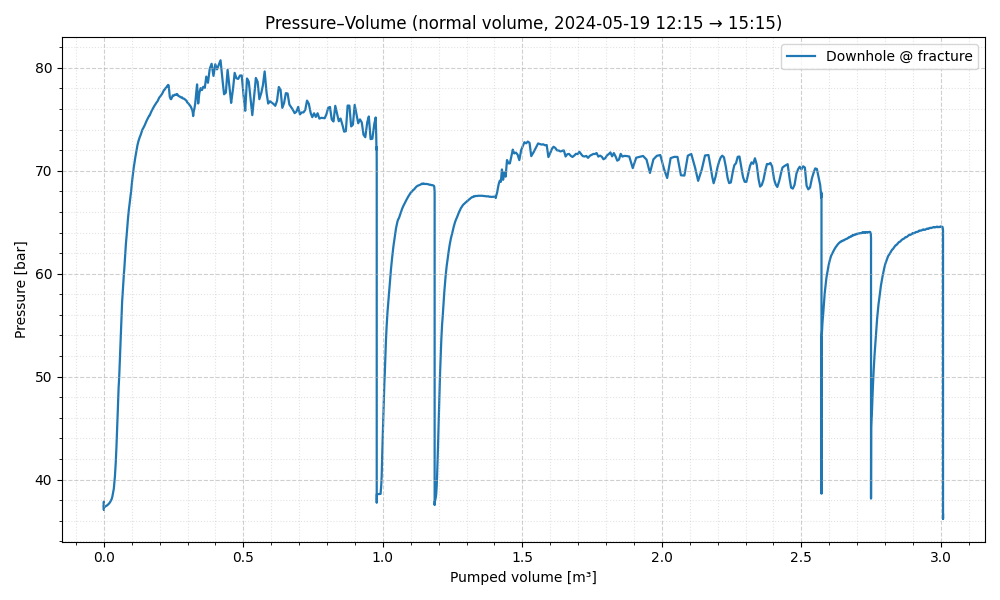

In [24]:
# ----------------------------
# Pressure vs Pumped Volume (entire START_D → END_D window)
# ----------------------------

# Mask based on timestamps
# Rename pumped volume to generic name

if "pumped_vol_m3" not in combined.columns:
    raise RuntimeError("pumped_vol_m3 has not been computed – check flow_lpm integration block.")

combined = combined.rename(columns={"pumped_vol_m3": "volume"})
mask_window = (combined.index >= START_D) & (combined.index <= END_D)

V    = combined.loc[mask_window, "volume"]
P_dh = combined.loc[mask_window, "P_dh_at_frac_bar"]


df_pv = pd.DataFrame({"V": V, "P_dh": P_dh}).dropna()

figPV, axPV = plt.subplots(figsize=(10, 6))
axPV.plot(
    df_pv["V"],
    df_pv["P_dh"],
    label="Downhole @ fracture",
    lw=1.6,
    zorder=0,
)

axPV.set_xlabel("Pumped volume [m³]")
axPV.set_ylabel("Pressure [bar]")
axPV.set_title(
    f"Pressure–Volume (normal volume, {START_D:%Y-%m-%d %H:%M} → {END_D:%H:%M})"
)

axPV.xaxis.set_major_locator(mticker.AutoLocator())
axPV.xaxis.set_minor_locator(mticker.AutoMinorLocator())
axPV.yaxis.set_major_locator(mticker.AutoLocator())
axPV.yaxis.set_minor_locator(mticker.AutoMinorLocator())

axPV.grid(True, which="major", linestyle="--", alpha=0.6)
axPV.grid(True, which="minor", linestyle=":",  alpha=0.35)

axPV.legend(loc="best")

plt.tight_layout()
plt.show()

Defined 5 manual cycles.


,start_idx,end_idx,t_start,t_end,duration,start_value,end_value,samples
0,20200,39900,2024-05-19 12:48:40,2024-05-19 13:21:30,0 days 00:32:50,0.014370,0.978044,19701
1,44150,47600,2024-05-19 13:28:35,2024-05-19 13:34:20,0 days 00:05:45,0.992519,1.185615,3451
2,53820,65200,2024-05-19 13:44:42,2024-05-19 14:03:40,0 days 00:18:58,1.187650,2.572287,11381
3,68510,75000,2024-05-19 14:09:11,2024-05-19 14:20:00,0 days 00:10:49,2.572287,2.749823,6491
4,78160,83300,2024-05-19 14:25:16,2024-05-19 14:33:50,0 days 00:08:34,2.750558,3.007960,5141


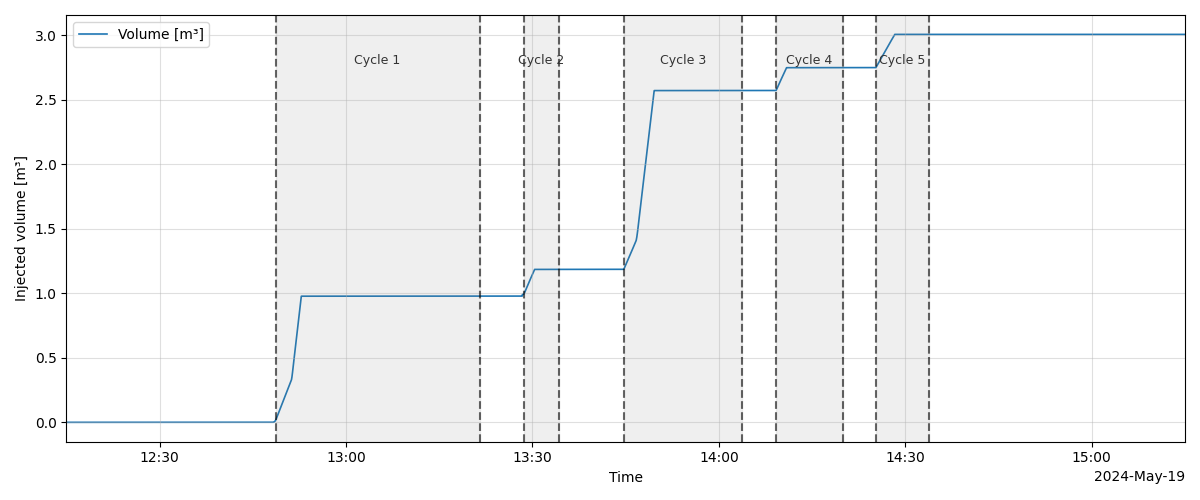

In [25]:
def build_cycles_df_from_manual(volume: pd.Series, cycles: list[dict]) -> pd.DataFrame:
    """
    Build a cycles_df from a manually defined list of cycles.

    cycles: list of dicts with keys:
        - "t_start": pd.Timestamp (or anything pd.to_datetime accepts)
        - "t_end":   pd.Timestamp (or anything pd.to_datetime accepts)
    """
    v = pd.Series(volume, copy=False).astype(float)
    idx = v.index

    rows = []
    for cyc in cycles:
        t_start = pd.to_datetime(cyc["t_start"])
        t_end   = pd.to_datetime(cyc["t_end"])

        if t_end <= t_start:
            continue

        # clip to available data range
        t_start_clipped = max(t_start, idx.min())
        t_end_clipped   = min(t_end, idx.max())

        # nearest indices in the volume series
        s_i = idx.get_indexer([t_start_clipped], method="nearest")[0]
        e_i = idx.get_indexer([t_end_clipped],   method="nearest")[0]
        if e_i < s_i:
            continue

        t_start_i = idx[s_i]
        t_end_i   = idx[e_i]
        duration  = t_end_i - t_start_i

        rows.append({
            "start_idx": int(s_i),
            "end_idx":   int(e_i),
            "t_start":   t_start_i,
            "t_end":     t_end_i,
            "duration":  duration,
            "start_value": float(v.iloc[s_i]) if np.isfinite(v.iloc[s_i]) else np.nan,
            "end_value":   float(v.iloc[e_i]) if np.isfinite(v.iloc[e_i]) else np.nan,
            "samples":   int(e_i - s_i + 1),
        })

    return pd.DataFrame(rows)

# restrict volume to your global window
vol_window = combined["volume"].loc[START_D:END_D]

cycles_df = build_cycles_df_from_manual(vol_window, CYCLES)
print(f"Defined {len(cycles_df)} manual cycles.")
display(cycles_df)



work = combined.loc[START_D:END_D]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(work.index, work["volume"], label="Volume [m³]", lw=1.2, zorder=1)

for i, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
    ax.axvline(cyc.t_start, color="k", ls="--", alpha=0.6)
    ax.axvline(cyc.t_end,   color="k", ls="--", alpha=0.6)
    ax.axvspan(cyc.t_start, cyc.t_end, color="grey", alpha=0.12)

    y_top = np.nanmax(work["volume"].values)
    t_mid = pd.to_datetime(cyc.t_start) + (pd.to_datetime(cyc.t_end) - pd.to_datetime(cyc.t_start)) / 2
    ax.text(
        t_mid,
        0.95 * y_top if np.isfinite(y_top) else 0.0,
        f"Cycle {i}",
        ha="center",
        va="top",
        fontsize=9,
        color="0.2",
    )

# adaptive x ticks (good for zooming)
xloc = mdates.AutoDateLocator()
xfmt = mdates.ConciseDateFormatter(xloc)
ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(xfmt)

ax.set_xlim(START_D, END_D)
ax.set_ylabel("Injected volume [m³]")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

Using 5 MANUAL cycles in window 2024-05-19 12:15:00 → 2024-05-19 15:15:00.


,start_idx,end_idx,t_start,t_end,duration,start_value,end_value,samples
0,20200,39900,2024-05-19 12:48:40,2024-05-19 13:21:30,0 days 00:32:50,0.014370,0.978044,19701
1,44150,47600,2024-05-19 13:28:35,2024-05-19 13:34:20,0 days 00:05:45,0.992519,1.185615,3451
2,53820,65200,2024-05-19 13:44:42,2024-05-19 14:03:40,0 days 00:18:58,1.187650,2.572287,11381
3,68510,75000,2024-05-19 14:09:11,2024-05-19 14:20:00,0 days 00:10:49,2.572287,2.749823,6491
4,78160,83300,2024-05-19 14:25:16,2024-05-19 14:33:50,0 days 00:08:34,2.750558,3.007960,5141


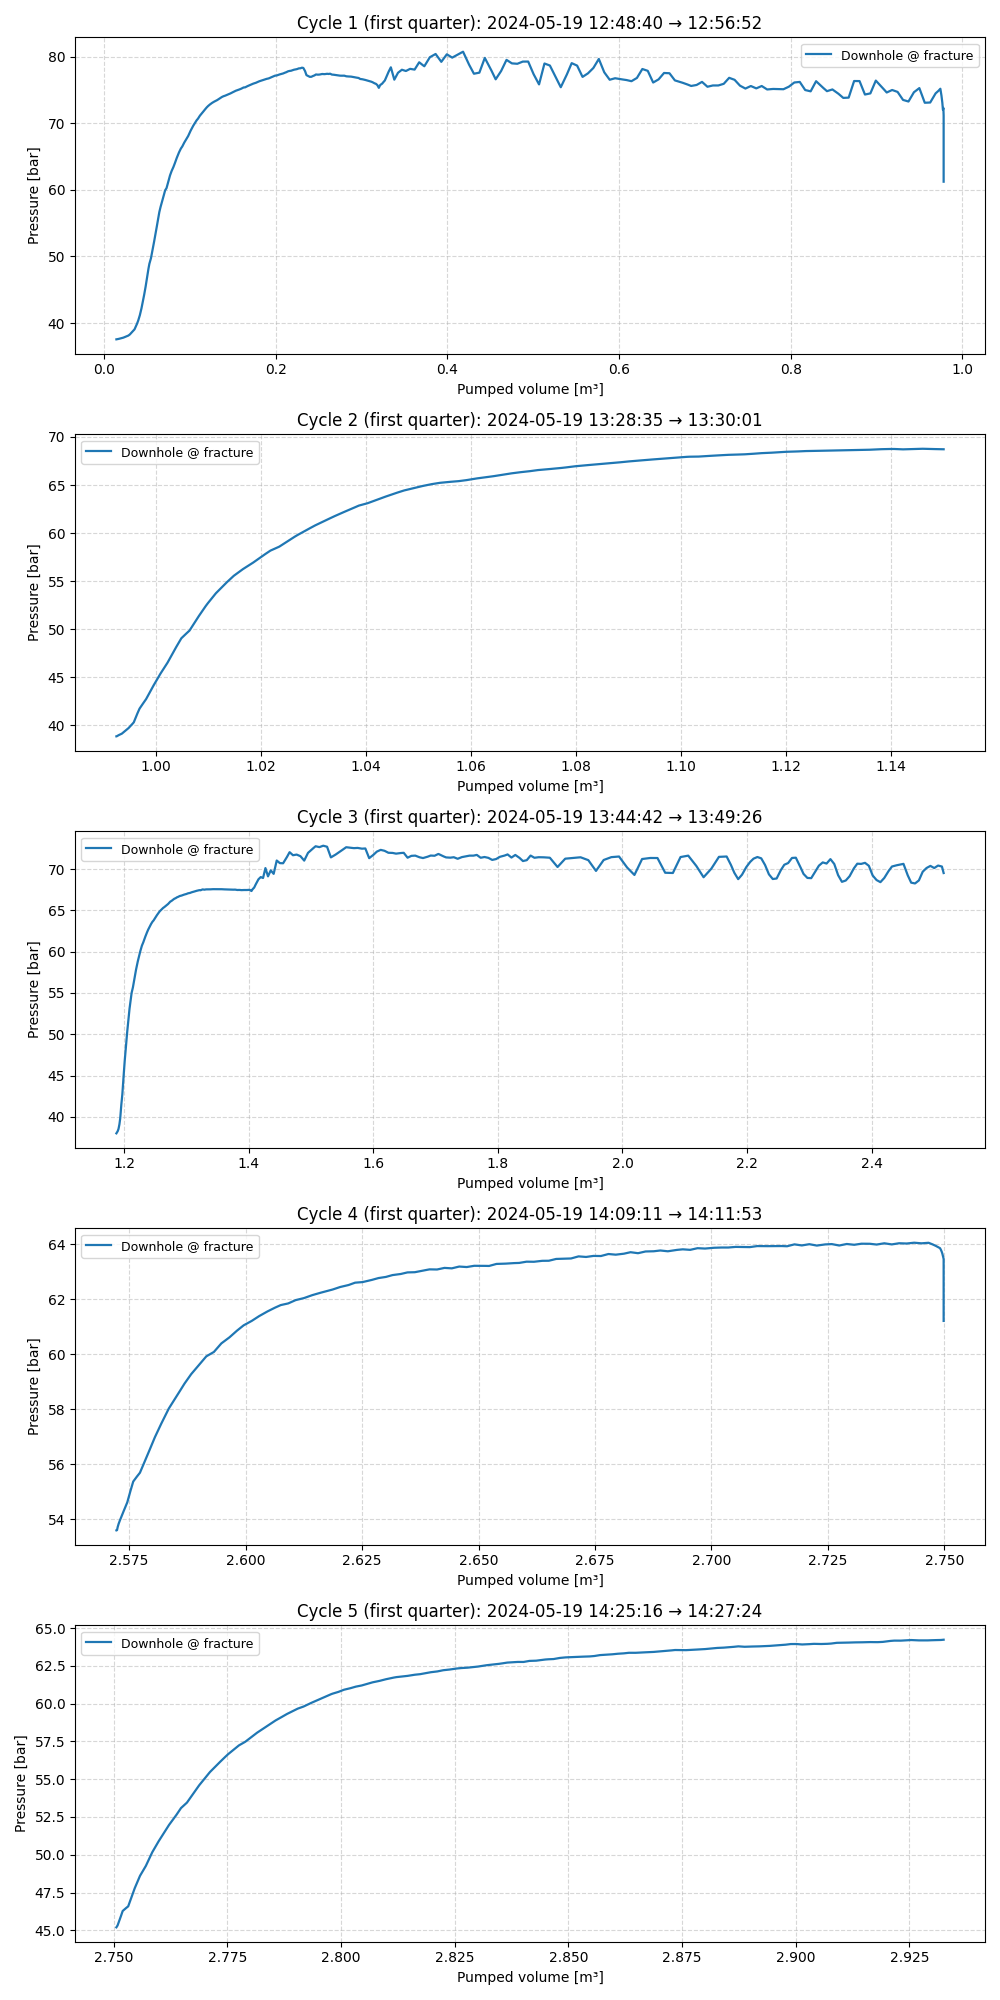

In [26]:
# ============================
# Plot Pressure vs Volume for each detected cycle (FIRST QUARTER by time)
# ============================


# 1) Build cycles_df from MANUAL cycles (no auto-detection)
vol_window = combined["volume"].loc[START_D:END_D]

cycles_df = build_cycles_df_from_manual(vol_window, CYCLES)
print(f"Using {len(cycles_df)} MANUAL cycles in window {START_D} → {END_D}.")
display(cycles_df)

# 2) Plot P–V for first quarter of each manual cycle
if len(cycles_df) == 0:
    print("No cycles to plot.")
else:
    work = combined.loc[START_D:END_D]
    n = len(cycles_df)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), squeeze=False)
    axes = axes.ravel()

    for k, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
        ax = axes[k-1]

        # --- First QUARTER by time based on manual cycle window ---
        t0 = pd.to_datetime(cyc.t_start)
        t1 = pd.to_datetime(cyc.t_end)
        if t1 <= t0:
            ax.text(0.5, 0.5, "Empty cycle", ha="center", va="center",
                    transform=ax.transAxes)
            ax.set_axis_off()
            continue

        t_quarter = t0 + (t1 - t0) / 4  # 25% of the manual cycle duration

        # Slice only the first quarter in time — ONLY downhole pressure
        df_cyc = work.loc[t0:t_quarter,
                          ["volume", "P_dh_at_frac_bar"]
                         ].dropna()

        if df_cyc.empty:
            ax.text(0.5, 0.5, "No data in first quarter", ha="center", va="center",
                    transform=ax.transAxes)
            ax.set_axis_off()
            continue

        # Plot P vs (instantaneous) volume for first quarter (downhole only)
        ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"],
                lw=1.6, label="Downhole @ fracture")

        ax.set_xlabel("Pumped volume [m³]")
        ax.set_ylabel("Pressure [bar]")
        ax.set_title(
            f"Cycle {k} (first quarter): "
            f"{t0:%Y-%m-%d %H:%M:%S} → {t_quarter:%H:%M:%S}"
        )

        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend(loc="best", fontsize=9)

    plt.tight_layout()
    plt.show()

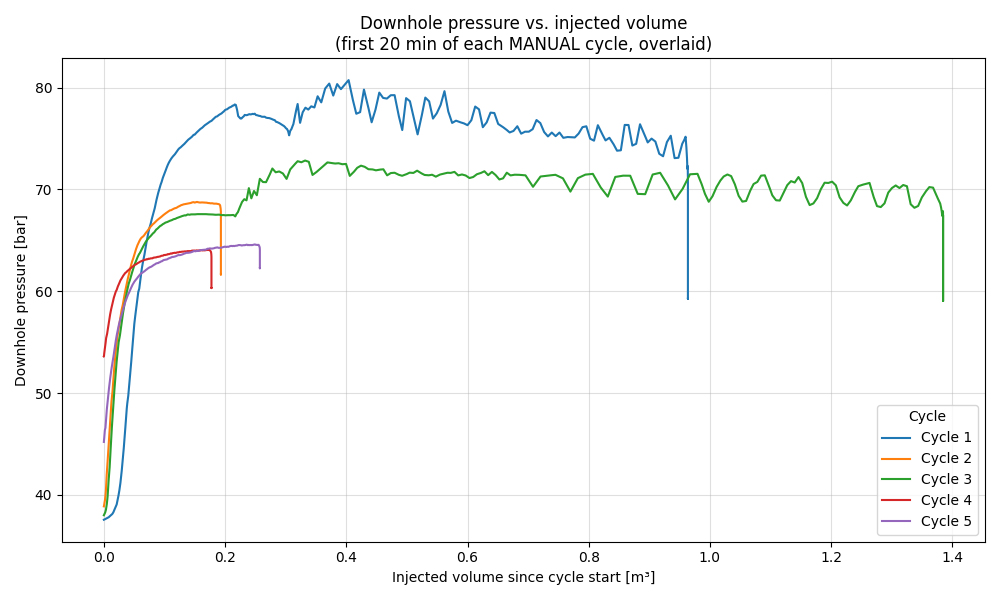

In [27]:
# =========================
# Plot P_dh vs *relative* Volume for ALL MANUAL cycles (overlaid)
# =========================

fig, ax = plt.subplots(figsize=(10, 6))

for i, cyc in enumerate(CYCLES, start=1):

    # Manual cycle start/end (surface/downhole time as you defined them)
    t_start = pd.to_datetime(cyc["t_start"])
    t_end   = pd.to_datetime(cyc["t_end"])

    # Plot only the first 20 minutes of each manual cycle
    t_end_plot = min(t_start + pd.Timedelta(minutes=20), t_end)

    # Slice downhole pressure + volume over [t_start, t_end_plot]
    segP = combined["P_dh_at_frac_bar"].loc[
        (combined.index >= t_start) &
        (combined.index <= t_end_plot)
    ]
    segV = combined["volume"].loc[
        (combined.index >= t_start) &
        (combined.index <= t_end_plot)
    ]

    if segP.empty or segV.empty:
        print(
            f"Cycle {i}: no usable data found in this window "
            f"({t_start} → {t_end_plot})."
        )
        continue

    # Shift volume so each cycle starts at 0 → overlay shapes
    segV_rel = segV.values - segV.values[0]

    # Plot Pressure vs *relative* Volume
    ax.plot(segV_rel, segP.values, lw=1.5, label=f"Cycle {i}")

# --- Formatting ---
ax.set_xlabel("Injected volume since cycle start [m³]")
ax.set_ylabel("Downhole pressure [bar]")
ax.set_title("Downhole pressure vs. injected volume\n"
             "(first 20 min of each MANUAL cycle, overlaid)")
ax.grid(True, alpha=0.4)
ax.legend(title="Cycle")

plt.tight_layout()
plt.show()

Manual end-time selected: 2024-05-19 12:56:52

Compliance regression:
  Using: 2024-05-19 12:48:40 → 2024-05-19 12:56:52
  Slope a = -3.747126e+00 bar/m³
  Intercept b = 7.079615e+01
  R² = 0.0254
  → Compliance = -2.669e-01 m³/bar (-266.871 L/bar)


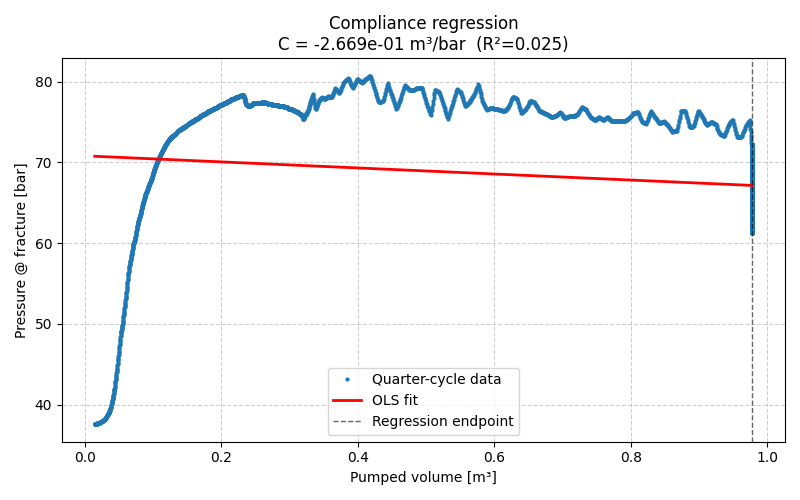

In [28]:
# ===========================================
# Compliance from first quarter of first MANUAL cycle (P vs V)
# WITH MANUAL END-POINT SELECTION
# ===========================================

# -------------------------------
# Manual pick settings
# -------------------------------
USE_MANUAL_PICK = True                         # True = override max-pressure pick
PICK_METHOD = "time"                           # "click" or "time"
MANUAL_END_TIME = "2024-12-20 10:43:00"        # only used if PICK_METHOD=="time"


# --- Select first manual cycle only ---
first_cyc = CYCLES[0]
t0 = pd.to_datetime(first_cyc["t_start"])
t1 = pd.to_datetime(first_cyc["t_end"])

# Optional: clip to data window if needed
t0 = max(t0, combined.index.min())
t1 = min(t1, combined.index.max())
if t1 <= t0:
    raise RuntimeError(f"Invalid first cycle window: {t0} → {t1}")

# First quarter in time of the manual cycle
t_quarter = t0 + (t1 - t0) / 4

# --- Subset to first quarter of first manual cycle ---
df_cyc = combined.loc[t0:t_quarter, ["volume", "P_dh_at_frac_bar"]].dropna()
if df_cyc.empty:
    raise RuntimeError("No valid data in first quarter of first manual cycle.")

# Default endpoint = automatic max pressure inside the quarter
imax_auto = df_cyc["P_dh_at_frac_bar"].idxmax()
end_time = imax_auto


# =======================================
# OPTION A — CLICK ON PLOT TO SET ENDPOINT
# =======================================
if USE_MANUAL_PICK and PICK_METHOD == "click":

    print("\n>>> Click the point up to which you want to perform the regression.")
    print(">>> Close the plot window after selecting.")

    fig_click, ax_click = plt.subplots(figsize=(8, 4))
    ax_click.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], 'o', ms=3)
    ax_click.set_title("Click desired end point for regression")
    ax_click.set_xlabel("Volume [m³]")
    ax_click.set_ylabel("Pressure [bar]")

    clicked = []

    def onclick(event):
        if event.xdata is None:
            return
        clicked.append((event.xdata, event.ydata))
        print(f"Clicked: volume={event.xdata:.4f}")

    cid = fig_click.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

    if len(clicked) == 0:
        print("No click detected → fallback to automatic max pressure.")
        end_time = imax_auto
    else:
        clicked_vol = clicked[-1][0]
        # Convert clicked volume to nearest timestamp in df_cyc
        idx = (df_cyc["volume"] - clicked_vol).abs().idxmin()
        end_time = idx
        print(f"Selected endpoint at time {end_time}")

# =======================================
# OPTION B — MANUAL TIMESTAMP ENTRY
# =======================================
elif USE_MANUAL_PICK and PICK_METHOD == "time":

    try:
        manual_dt = pd.to_datetime(MANUAL_END_TIME)
        # Clamp to valid range
        if manual_dt < df_cyc.index.min():
            manual_dt = df_cyc.index.min()
        if manual_dt > df_cyc.index.max():
            manual_dt = df_cyc.index.max()
        end_time = manual_dt
        print(f"Manual end-time selected: {end_time}")
    except Exception as e:
        print(f"Invalid MANUAL_END_TIME: {e} → fallback to auto pick.")
        end_time = imax_auto


# =================================================
# Build regression subset df_fit from t0 → end_time
# =================================================
df_fit = df_cyc.loc[:end_time]
if df_fit.empty:
    raise RuntimeError("Regression window is empty.")

# ========== Linear regression ==========
V = df_fit["volume"].values
P = df_fit["P_dh_at_frac_bar"].values
coeffs = np.polyfit(V, P, 1)
slope, intercept = coeffs  # slope = dP/dV
P_fit = np.poly1d(coeffs)

# ========== Compliance ==========
if slope != 0:
    C_m3_per_bar = 1.0 / slope
    C_L_per_bar  = C_m3_per_bar * 1e3
else:
    C_m3_per_bar = np.nan
    C_L_per_bar  = np.nan

# ========== R² ==========
residuals = P - P_fit(V)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((P - np.mean(P))**2)
r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

# ========== Print report ==========
print(f"\nCompliance regression:")
print(f"  Using: {t0} → {end_time}")
print(f"  Slope a = {slope:.6e} bar/m³")
print(f"  Intercept b = {intercept:.6e}")
print(f"  R² = {r2:.4f}")
print(f"  → Compliance = {C_m3_per_bar:.3e} m³/bar ({C_L_per_bar:.3f} L/bar)")

# ========== Final plot ==========
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], 'o', ms=2, label="Quarter-cycle data")
ax.plot(df_fit["volume"], P_fit(df_fit["volume"]), 'r-', lw=2, label="OLS fit")
ax.axvline(df_fit["volume"].iloc[-1], color='k', ls='--', lw=1, alpha=0.6, label="Regression endpoint")

ax.set_xlabel("Pumped volume [m³]")
ax.set_ylabel("Pressure @ fracture [bar]")
ax.set_title(f"Compliance regression\nC = {C_m3_per_bar:.3e} m³/bar  (R²={r2:.3f})")
ax.grid(True, ls='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

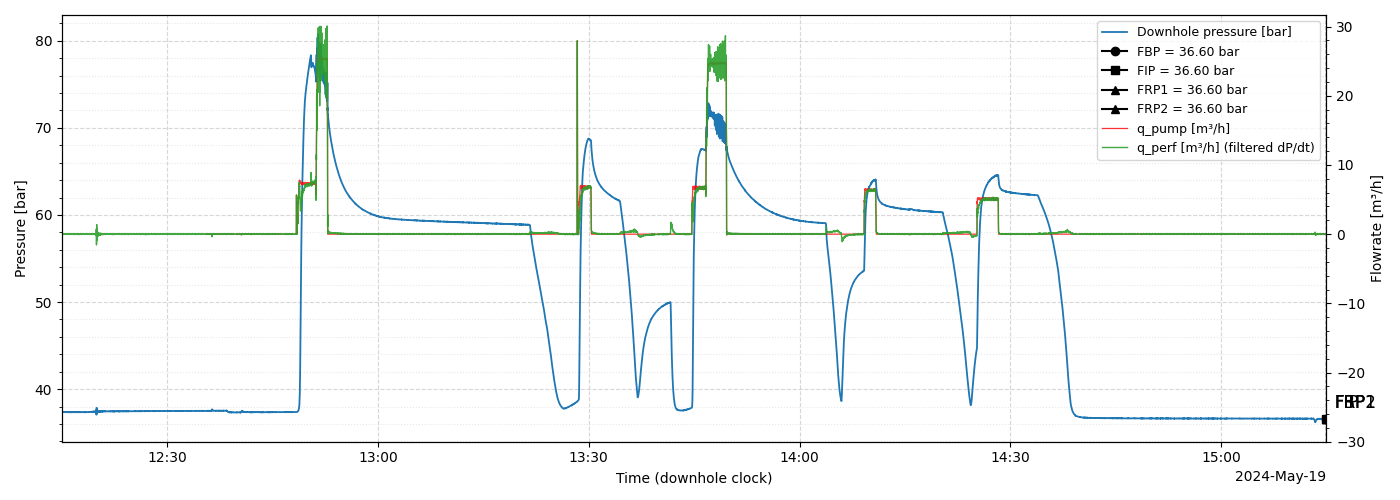

In [29]:
# ============================
# FIP / FBP / FRP overlay with q_pump, q_perf, and P_dh (downhole clock)
# ============================

# ---- Inputs (set these) ----
C_WELL = C_m3_per_bar  # m³/bar  (system/wellbore compliance used for q_perf calculation)

C_WELL = 0.00065

# Optional manual picks on the DOWNHOLE clock:
FIP_TIME    = pd.Timestamp("2024-12-20 10:43:24")
FRP_TIME_1  = pd.Timestamp("2024-12-20 11:23:45")
FRP_TIME_2  = pd.Timestamp("2024-12-20 12:00:00")

FRP_TIMES = [FRP_TIME_1, FRP_TIME_2]

# ---- NEW: manual FBP option ----
USE_MANUAL_FBP  = True  # set to True to override automatic FBP
MANUAL_FBP_TIME = pd.Timestamp("2024-12-20 10:43:58")  # example; edit as needed

# ---- Pull series (window-aware) ----
work = combined.loc[START_D:END_D].copy()

# ============================================================
# q_pump from cementing-unit flow_rate (L/min → m³/h)
# ============================================================

# flow_lpm is in L/min → convert to m³/h
q_pump_Lmin = pd.to_numeric(work["flow_lpm"], errors="coerce")  # L/min
work["q_pump_m3h_raw"] = q_pump_Lmin * 0.06                     # m³/h

# Light smoothing on the pump rate (5 samples ~ 0.625 s at 0.125 s/sample)
work["q_pump_m3h"] = (
    work["q_pump_m3h_raw"]
    .rolling(5, center=True, min_periods=1)
    .mean()
)

# Remove extreme negative values (outlier protection)
work.loc[work["q_pump_m3h"] < -100, "q_pump_m3h"] = np.nan
work.loc[work["q_pump_m3h_raw"] < -100, "q_pump_m3h_raw"] = np.nan

# ============================================================
# Downhole pressure [bar]: unsmoothed for plotting & picks
# ============================================================
P_dh = (
    work["P_dh_at_frac_bar"]
    .astype(float)
    .sort_index()
)

P_dh = P_dh[~P_dh.index.duplicated(keep="first")].interpolate(
    "time", limit_direction="both"
)

# ============================================================
# Noise-aware dP/dt for q_perf
#   - low-pass filter P_dh
#   - compute gradient
#   - smooth dP/dt itself
# ============================================================

# 1) Low-pass filter pressure used ONLY for derivative
#    (9 samples ~ 1.125 s at 0.125 s/sample)
P_dh_lp = (
    P_dh
    .rolling(9, center=True, min_periods=1)
    .mean()
)

# 2) dP/dt from low-pass pressure
ts = (P_dh_lp.index - P_dh_lp.index[0]).total_seconds().to_numpy()
dPdt_raw = np.gradient(P_dh_lp.to_numpy(), ts)  # bar/s

# 3) Additional light smoothing on dP/dt itself
dPdt_series = pd.Series(dPdt_raw, index=P_dh_lp.index)
dPdt_filt = (
    dPdt_series
    .rolling(5, center=True, min_periods=1)
    .mean()
)

# ============================================================
# q_perf from q_pump using filtered dP/dt  (noise-aware)
# ============================================================

# Align q_pump to the same index as P_dh_lp
q_pump_m3h_aligned = (
    work["q_pump_m3h"]
    .reindex(P_dh_lp.index)
    .interpolate("time", limit_direction="both")
)

# Convert q_pump to m³/s, subtract C_WELL * dP/dt (m³/s), then back to m³/h
q_perf_m3h = (q_pump_m3h_aligned / 3600.0 - C_WELL * dPdt_filt) * 3600.0  # m³/h

# store for plotting
work["q_perf_m3h"] = q_perf_m3h.reindex(work.index).interpolate(
    "time", limit_direction="both"
)

# ---- Helper: robust time interpolation on DH-indexed series ----
def _interp_time(series_dt: pd.Series, t_query: pd.Timestamp):
    s = series_dt.sort_index()
    s = s[~s.index.duplicated(keep="first")].interpolate(
        method="time", limit_direction="both"
    )
    t_min, t_max = s.index.min(), s.index.max()
    tq = min(max(pd.Timestamp(t_query), t_min), t_max)
    val = s.reindex(s.index.union([tq])).interpolate(method="time").loc[tq]
    return tq, float(val)


# ---- Picks ----

# --- FBP: manual option or automatic in first cycle ---
if USE_MANUAL_FBP and (MANUAL_FBP_TIME is not None):
    # Manual FBP: interpolate pressure at the given timestamp
    t_FBP, FBP_bar = _interp_time(P_dh, pd.Timestamp(MANUAL_FBP_TIME))
else:
    # Automatic FBP restricted to FIRST cycle from CYCLES
    cycle1_start = CYCLES[0]["t_start"]
    cycle1_end   = CYCLES[0]["t_end"]

    # Clamp the cycle window to the actual P_dh data range (defensive)
    t_min, t_max = P_dh.index.min(), P_dh.index.max()
    cycle1_start = max(cycle1_start, t_min)
    cycle1_end   = min(cycle1_end,   t_max)

    P_dh_cycle1 = P_dh.loc[cycle1_start:cycle1_end]

    if not P_dh_cycle1.empty:
        # FBP from first cycle ONLY
        t_FBP = P_dh_cycle1.idxmax()
    else:
        # Fallback: if window is empty for some reason, use global max
        t_FBP = P_dh.idxmax()

    FBP_bar = float(P_dh.loc[t_FBP])

# FIP
FIP_info = None
if FIP_TIME is not None:
    t_FIP_q, P_FIP = _interp_time(P_dh, pd.Timestamp(FIP_TIME))
    FIP_info = (t_FIP_q, P_FIP)

# FRPs
FRP_infos = []
for t_FRP in FRP_TIMES:
    if t_FRP is None:
        continue
    t_FRP_q, P_FRP = _interp_time(P_dh, pd.Timestamp(t_FRP))
    FRP_infos.append((t_FRP_q, P_FRP))


# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(14, 5))

t_dh = P_dh.index

# Pressure on primary axis (unsmoothed)
ax1.plot(t_dh, P_dh, color="C0", lw=1.3, zorder=3,
         label="Downhole pressure [bar]")

ax1.set_xlabel("Time (downhole clock)")
ax1.set_ylabel("Pressure [bar]")

xloc = mdates.AutoDateLocator()
xfmt = mdates.ConciseDateFormatter(xloc)
ax1.xaxis.set_major_locator(xloc)
ax1.xaxis.set_major_formatter(xfmt)

ax1.yaxis.set_major_locator(mticker.AutoLocator())
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)
ax1.grid(True, which="minor", axis="both", linestyle=":",  alpha=0.3)

# Secondary axis for TRUE flowrates (derived)
ax2 = ax1.twinx()

ax2.plot(
    work.index,
    work["q_pump_m3h"],
    color="red",
    lw=0.9,
    alpha=0.8,
    zorder=1,
    label="q_pump [m³/h]",
)

ax2.plot(
    work.index,
    work["q_perf_m3h"],
    color="C2",
    lw=1.0,
    alpha=0.9,
    zorder=2,
    label="q_perf [m³/h] (filtered dP/dt)",
)

ax2.set_ylabel("Flowrate [m³/h]")
ax2.yaxis.set_major_locator(mticker.AutoLocator())
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())

# Force scale to start at -20 m³/h
ax2.set_ylim(bottom=-30)

# ========= Vertical lines & markers =========

# FBP
ax1.axvline(t_FBP, color="black", linestyle="--", lw=0.8, alpha=0.9)
ax1.plot(t_FBP, FBP_bar, marker="o", ms=6, color="black", zorder=5,
         label=f"FBP = {FBP_bar:.2f} bar")
ax1.annotate("FBP", xy=(t_FBP, FBP_bar), xytext=(6, 8),
             textcoords="offset points", color="black", fontsize=12)

# FIP
if FIP_info is not None:
    t_FIP_q, P_FIP = FIP_info
    ax1.axvline(t_FIP_q, color="black", linestyle="--", lw=0.8)
    ax1.plot(t_FIP_q, P_FIP, marker="s", ms=6, color="black",
             label=f"FIP = {P_FIP:.2f} bar")
    ax1.annotate("FIP", xy=(t_FIP_q, P_FIP), xytext=(6, 8),
                 textcoords="offset points", color="black", fontsize=12)

# FRPs
for j, (t_FRP_q, P_FRP) in enumerate(FRP_infos, start=1):
    ax1.axvline(t_FRP_q, color="black", linestyle="--", lw=0.8)
    ax1.plot(t_FRP_q, P_FRP, marker="^", ms=6, color="black",
             label=f"FRP{j} = {P_FRP:.2f} bar")
    ax1.annotate(f"FRP{j}", xy=(t_FRP_q, P_FRP), xytext=(6, 8),
                 textcoords="offset points", color="black", fontsize=12)

# ---- Legend ----
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="best", fontsize=9)

ax1.set_xlim(START_D, END_D)
plt.tight_layout()
plt.show()

In [30]:
# ============================================================
# Store compliance + FIP / FRP / FBP times & pressures in one DF
# ============================================================

event_rows = []

# FIP
if FIP_info is not None:
    t_FIP_q, P_FIP = FIP_info
    event_rows.append({
        "event": "FIP",
        "time": t_FIP_q,
        "P_bar": P_FIP,
        "C_well_m3_per_bar": C_WELL,
    })

# FRPs
for j, (t_FRP_q, P_FRP) in enumerate(FRP_infos, start=1):
    event_rows.append({
        "event": f"FRP{j}",
        "time": t_FRP_q,
        "P_bar": P_FRP,
        "C_well_m3_per_bar": C_WELL,
    })

# FBP
event_rows.append({
    "event": "FBP",
    "time": t_FBP,
    "P_bar": FBP_bar,
    "C_well_m3_per_bar": C_WELL,
})

df_events = pd.DataFrame(event_rows)

# Optional: sort by time if you like
df_events = df_events.sort_values("time").reset_index(drop=True)

print("\n=== Event summary (compliance + FIP/FRP/FBP) ===\n")
display(df_events)


=== Event summary (compliance + FIP/FRP/FBP) ===



,event,time,P_bar,C_well_m3_per_bar
0,FIP,2024-05-19 15:15:00,36.599701,0.00065
1,FRP1,2024-05-19 15:15:00,36.599701,0.00065
2,FRP2,2024-05-19 15:15:00,36.599701,0.00065
3,FBP,2024-05-19 15:15:00,36.599701,0.00065


# Falloff Analysis
## Time transformation and cycles


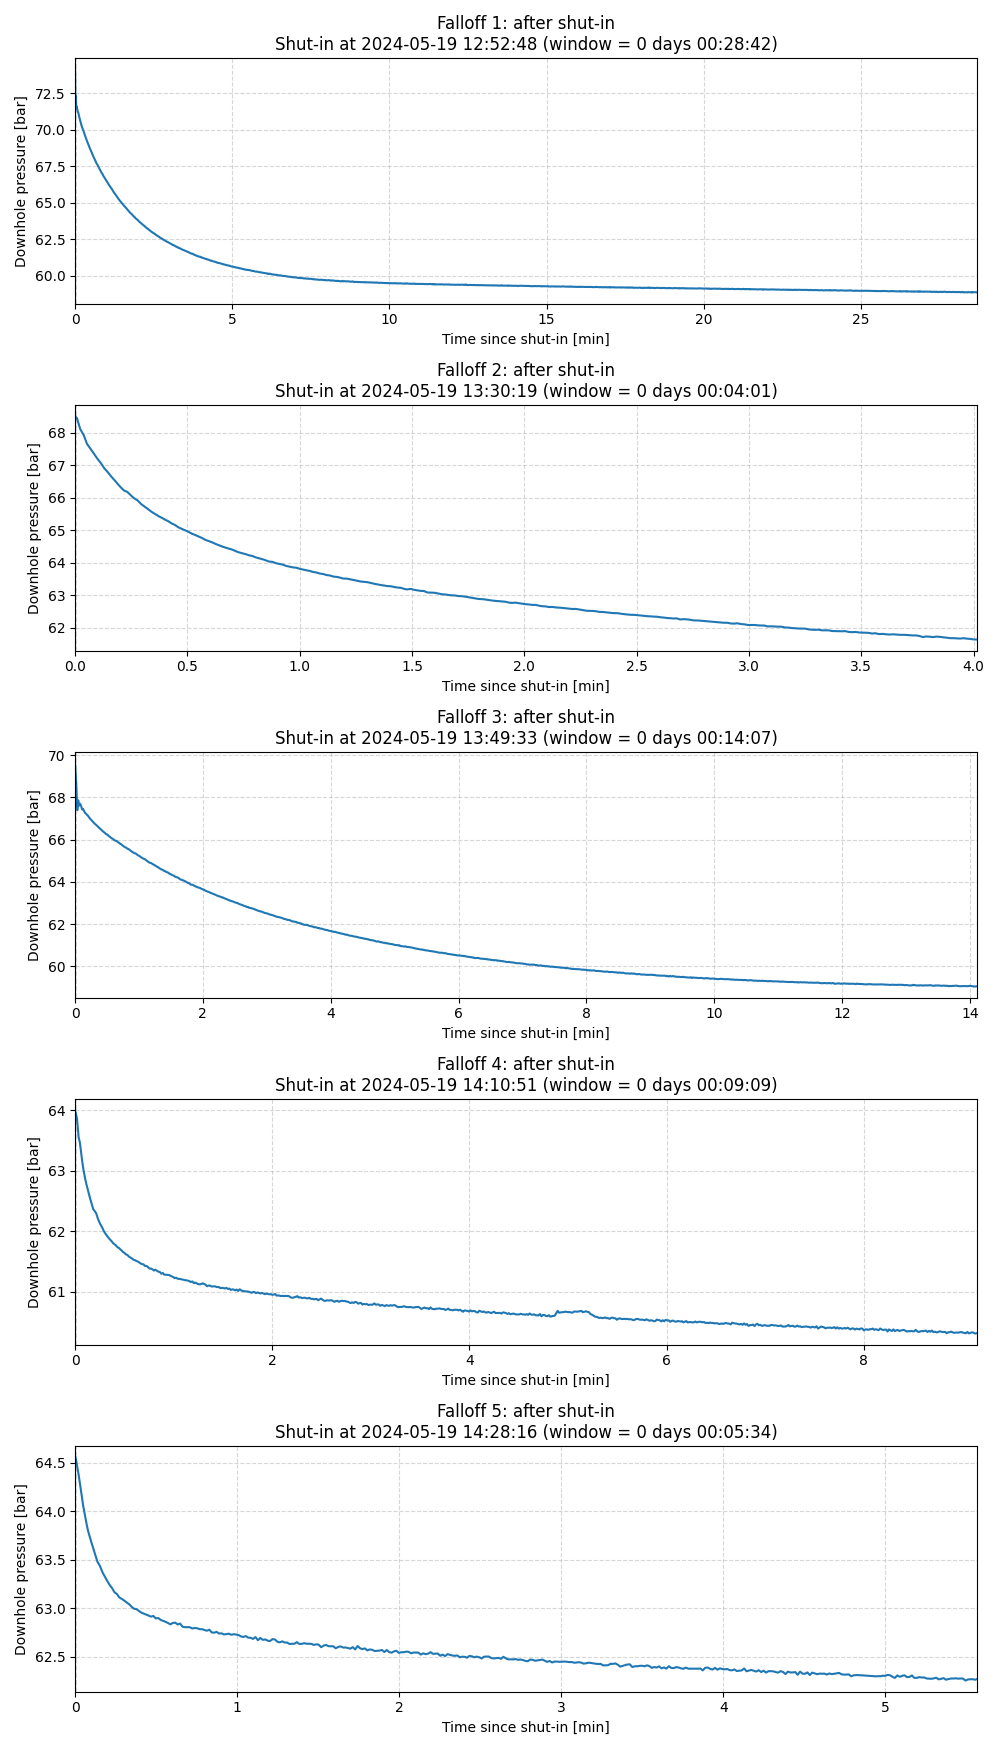

In [31]:
# ============================
# Settings
# ============================

# Duration of falloff window
falloff_window = [
    cyc["t_end"] - cyc["t_shutin"]
    for cyc in CYCLES
]

# Shut-in times on the DOWNHOLE clock, defined as the start of this notebook

# ============================
# Plot falloffs: one subplot per shut-in
# ============================

P_series = combined["P_dh_at_frac_bar"].astype(float)  # downhole @ fracture, bar
P_series = P_series.sort_index()

n = len(CYCLES)
if n == 0:
    print("No cycles defined – nothing to plot.")
else:
    fig, axes = plt.subplots(n, 1, figsize=(10, 3.5 * n), squeeze=False)
    axes = axes.ravel()

    for i, (ax, cyc) in enumerate(zip(axes, CYCLES), start=1):
        # Shut-in and end times from CYCLES
        t_shut = pd.to_datetime(cyc["t_shutin"])
        t_end  = pd.to_datetime(cyc["t_end"])

        # Falloff window = t_end - t_shutin
        falloff_window = t_end - t_shut

        # Slice pressure series over [t_shut, t_end]
        p_seg = P_series.loc[
            (P_series.index >= t_shut) & (P_series.index <= t_end)
        ].dropna()

        if p_seg.empty:
            ax.text(
                0.5, 0.5,
                f"No data in falloff window for cycle {i}",
                ha="center", va="center", transform=ax.transAxes
            )
            ax.set_axis_off()
            continue

        # Time axis as minutes since shut-in
        t_rel_min = (p_seg.index - t_shut) / pd.Timedelta(minutes=1)

        # Plot
        ax.plot(t_rel_min, p_seg, lw=1.5, color="tab:blue")
        ax.axvline(0.0, color="k", ls="--", lw=1.0, alpha=0.7)

        # Labels & title
        ax.set_xlabel("Time since shut-in [min]")
        ax.set_ylabel("Downhole pressure [bar]")
        ax.set_title(
            f"Falloff {i}: after shut-in\n"
            f"Shut-in at {t_shut:%Y-%m-%d %H:%M:%S} "
            f"(window = {falloff_window})"
        )
        ax.grid(True, which="both", linestyle="--", alpha=0.5)

        # X-limits exactly to the falloff window length
        ax.set_xlim(0, falloff_window / pd.Timedelta(minutes=1))

    plt.tight_layout()
    plt.show()

In [32]:
def g_nolte_delta_tD(delta_t_since_shutin_s, t_p_seconds, alpha=0.5):
    """
    Nolte / Carter g-function g(Δt) for leakoff, where:

        Δt = t - t_shutin   (time since shut-in, in seconds)
        t_p = injection time (pumping duration from start of injection into fracture
                              until shut-in), in seconds

    Dimensionless variable:
        u = Δt / t_p  >= 0

    For α = 1/2 (Carter-type leakoff with constant-height fracture), the "most common"
    form (Gulrajani & Nolte, 2001) is:

        g(Δt) = 4/3 * [ (1 + u)^(3/2) - u^(3/2) ],   u = Δt / t_p

    We also include an upper bound for α = 1 (different growth assumption), and for
    0.5 < α < 1 we linearly interpolate between the two shapes:

        g_lower(u) = 4/3 * [ (1 + u)^(3/2) - u^(3/2) ]
        g_upper(u) = (1 + u) * arcsin( (1 + u)^(-1/2) ) + u^(1/2)

    Parameters
    ----------
    delta_t_since_shutin_s : array-like
        Time since shut-in Δt (seconds). Δt = 0 at shut-in.
    t_p_seconds : float
        Injection time t_p (seconds) for that cycle.
    alpha : float in [0.5, 1]
        Shape parameter (0.5 = lower bound, 1 = upper bound, interpolate in between).

    Returns
    -------
    g : np.ndarray
        Dimensionless g-function values g(Δt) at the given Δt / t_p.
    """
    import numpy as np

    delta_t_since_shutin_s = np.asarray(delta_t_since_shutin_s, dtype=float)
    t_p_seconds = float(t_p_seconds)
    if t_p_seconds <= 0:
        raise ValueError("t_p_seconds must be positive (injection duration).")

    # u = Δt / t_p  (dimensionless time since shut-in)
    u = np.clip(delta_t_since_shutin_s / t_p_seconds, 0.0, None)

    # Lower bound α = 1/2
    g_lower = (4.0 / 3.0) * ((1.0 + u)**1.5 - u**1.5)

    # Upper bound α = 1
    with np.errstate(invalid="ignore"):
        g_upper = (1.0 + u) * np.arcsin(1.0 / np.sqrt(1.0 + u)) + np.sqrt(u)

    alpha_clamped = min(max(alpha, 0.5), 1.0)
    if np.isclose(alpha_clamped, 0.5):
        return g_lower
    if np.isclose(alpha_clamped, 1.0):
        return g_upper

    w = (alpha_clamped - 0.5) / 0.5   # 0 at 0.5, 1 at 1
    return g_lower + w * (g_upper - g_lower)

In [33]:
# -------------------------------------------
# 1) Injection durations per cycle (downhole clock)
# -------------------------------------------

# Start picks on DH clock (must already be defined)
cycle_start_times = [
    FIP_TIME,      # Cycle 1 starts at FIP
    FRP_TIME_1,    # Cycle 2 starts at first FRP
    FRP_TIME_2
]

manual_shutins_dh = [cyc["t_shutin"] for cyc in CYCLES]

rows = []
for i, (t_start, t_shut) in enumerate(zip(cycle_start_times, manual_shutins_dh), start=1):
    if t_start is None or t_shut is None:
        print(f"Cycle {i}: missing start or shut-in time, skipping.")
        continue

    t_start = pd.to_datetime(t_start)
    t_shut  = pd.to_datetime(t_shut)

    if t_shut <= t_start:
        print(f"Cycle {i}: shut-in time ≤ start time, skipping.")
        continue

    duration   = t_shut - t_start
    duration_s = duration.total_seconds()

    rows.append({
        "cycle":      i,
        "t_start":    t_start,
        "t_shut":     t_shut,
        "duration":   duration,
        "duration_s": duration_s,
    })

inj_cycles_df = pd.DataFrame(rows, columns=["cycle", "t_start", "t_shut", "duration", "duration_s"])

print("Injection durations per cycle (downhole clock):")
display(inj_cycles_df)

# -------------------------------------------
# 2) Build inj_cycles dict from inj_cycles_df
# -------------------------------------------

inj_cycles = {}  # cycle_index -> dict with times & tp

for row in inj_cycles_df.itertuples(index=False):
    cyc_id     = int(row.cycle)
    t_start    = pd.to_datetime(row.t_start)
    t_shut     = pd.to_datetime(row.t_shut)
    duration_s = float(row.duration_s)

    # duration checks
    if duration_s <= 0 or t_shut <= t_start:
        print(f"Cycle {cyc_id}: invalid duration, skipping.")
        continue

    # get falloff duration for this cycle
    fall_dur = (CYCLES[cyc_id - 1]["t_end"] - CYCLES[cyc_id - 1]["t_shutin"])

    inj_cycles[cyc_id] = {
        "t_inj_start":  t_start,
        "t_shut":       t_shut,
        "t_p_seconds":  duration_s,
        "t_fall_start": t_shut,
        "t_fall_end":   t_shut + fall_dur,
        "fall_dur":     fall_dur,
    }

print(f"Built inj_cycles for {len(inj_cycles)} cycles from inj_cycles_df.")

# -------------------------------------------
# 3) Compute g(Δt), G(Δt) for each cycle → G_cycles
# -------------------------------------------

ALPHA_G = 0.5  # Carter lower bound; you can change to 1.0 or interpolate

G_cycles = {}   # cycle_index -> DataFrame with Δt, tD, g, G, P

P_dh_full = combined["P_dh_at_frac_bar"].astype(float)

for cyc_id, info in inj_cycles.items():
    t_shut      = info["t_shut"]
    t_fall_start = info["t_fall_start"]
    t_fall_end   = info["t_fall_end"]
    t_p_seconds  = info["t_p_seconds"]   # injection duration t_p

    # Segment of falloff data
    seg = P_dh_full.loc[t_fall_start:t_fall_end].dropna()
    if seg.empty:
        print(f"Cycle {cyc_id}: no data in falloff window {t_fall_start} → {t_fall_end}.")
        continue

    df = seg.to_frame(name="P_dh_at_frac_bar")

    # Δt = time since shut-in, in seconds
    delta_t_s = (df.index - t_shut).total_seconds()
    df["delta_t_s"] = delta_t_s
    df["tD"]        = delta_t_s / t_p_seconds   # dimensionless Δt/t_p

    # g(Δt) from Nolte/Carter
    g_vals = g_nolte_delta_tD(delta_t_s, t_p_seconds, alpha=ALPHA_G)
    df["g"] = g_vals

    # g(0) is g at Δt=0 → first sample at/after shut-in
    g0 = float(g_vals[0])

    # G(Δt) = 4/π [g(Δt) - g(0)]
    G_vals = (4.0 / np.pi) * (g_vals - g0)
    df["G"] = G_vals

    G_cycles[cyc_id] = df

# Quick check print
for cyc_id in sorted(G_cycles.keys()):
    df = G_cycles[cyc_id]
    print(f"\nCycle {cyc_id}:")
    print(df[["delta_t_s", "tD", "g", "G", "P_dh_at_frac_bar"]].head())

# -------------------------------------------
# 4) ONE FIGURE PER CYCLE: Δt, √Δt, G(Δt) stacked x-axes
# -------------------------------------------

if not G_cycles:
    print("No G-function data available. Make sure G_cycles is filled first.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        # time since shut-in in seconds
        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        # keep only finite points
        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points to plot.")
            continue

        # time transforms
        dt_min      = dt_s / 60.0           # Δt in minutes
        sqrt_dt_min = np.sqrt(dt_min)       # √Δt [min^0.5]

        fig = plt.figure(figsize=(9, 6))
        fig.subplots_adjust(bottom=0.25)    # space for extra x-axes

        # Base axis: P vs Δt
        ax_t = fig.add_subplot(111)
        line_t, = ax_t.plot(dt_min, P, color="C0", lw=1.4, label="Δt")
        ax_t.set_ylabel("Pressure [bar]")
        ax_t.set_xlabel("Δt [min]")
        ax_t.set_title(f"Cycle {cyc_id}: falloff time transforms")
        ax_t.grid(True, linestyle="--", alpha=0.5)
        ax_t.set_xlim(dt_min.min(), dt_min.max())

        # Second x-axis: √Δt (below main)
        ax_sqrt = ax_t.twiny()
        line_sqrt, = ax_sqrt.plot(sqrt_dt_min, P, color="C1", lw=1.4, label="√Δt")

        ax_sqrt.spines["top"].set_visible(False)
        ax_sqrt.xaxis.set_ticks_position("bottom")
        ax_sqrt.xaxis.set_label_position("bottom")
        ax_sqrt.spines["bottom"].set_position(("axes", -0.20))
        ax_sqrt.patch.set_alpha(0.0)
        ax_sqrt.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
        ax_sqrt.yaxis.set_visible(False)
        ax_sqrt.set_xlim(sqrt_dt_min.min(), sqrt_dt_min.max())

        # Third x-axis: G(Δt) (below √Δt axis)
        ax_G = ax_t.twiny()
        line_G, = ax_G.plot(Gval, P, color="C2", lw=1.4, label="G(Δt)")

        ax_G.spines["top"].set_visible(False)
        ax_G.xaxis.set_ticks_position("bottom")
        ax_G.xaxis.set_label_position("bottom")
        ax_G.spines["bottom"].set_position(("axes", -0.40))
        ax_G.patch.set_alpha(0.0)
        ax_G.set_xlabel(r"$G(\Delta t)$")
        ax_G.yaxis.set_visible(False)

        if np.isfinite(Gval.min()) and np.isfinite(Gval.max()) and Gval.max() > Gval.min():
            ax_G.set_xlim(Gval.min(), Gval.max())

        # Combined legend
        handles = [line_t, line_sqrt, line_G]
        labels  = ["Δt", r"$\sqrt{\Delta t}$", r"$G(\Delta t)$"]
        ax_t.legend(handles, labels, loc="upper right", fontsize=9)

        plt.tight_layout()
        plt.show()

#Check if G-function is computed correctly!

Cycle 1: shut-in time ≤ start time, skipping.
Cycle 2: shut-in time ≤ start time, skipping.
Cycle 3: shut-in time ≤ start time, skipping.
Injection durations per cycle (downhole clock):


,cycle,t_start,t_shut,duration,duration_s


Built inj_cycles for 0 cycles from inj_cycles_df.
No G-function data available. Make sure G_cycles is filled first.


## Results Initialization

In [34]:
# ============================================
# Global containers for FCP / closure results
# ============================================

# Structure:
# FCP_PICKS[cycle_id][method_name] = (t_closure_s, P_closure_bar)
FCP_PICKS: Dict[int, Dict[str, Tuple[Optional[float], Optional[float]]]] = {}


def reset_fcp_picks() -> None:
    """
    Clear all stored FCP/closure picks.
    Call this if you want to rerun all picking from scratch.
    """
    FCP_PICKS.clear()


def record_fcp_pick(
    cycle_id: int,
    method: str,
    t_closure_s: Optional[float],
    P_closure_bar: Optional[float],
) -> None:
    """
    Store closure time and pressure for a given cycle and method.

    Parameters
    ----------
    cycle_id : int
        Cycle index (1, 2, 3, ...).
    method : str
        Name of the method, e.g. "castillo", "haimson", "barree",
        "stiff", "first_max", ...
    t_closure_s : float or None
        Closure time in seconds since shut-in (Δt). None if no pick.
    P_closure_bar : float or None
        Closure pressure in bar. None if no pick.
    """
    if cycle_id not in FCP_PICKS:
        FCP_PICKS[cycle_id] = {}
    FCP_PICKS[cycle_id][method] = (t_closure_s, P_closure_bar)


def fcp_picks_as_dataframe() -> pd.DataFrame:
    """
    Return all stored FCP picks as a tidy DataFrame:

        index: (cycle, method)
        columns: t_closure_s, P_closure_bar

    This can be used for export, further stats, etc.
    """
    rows = []
    for cyc_id, methods in FCP_PICKS.items():
        for method, (t_s, P_bar) in methods.items():
            rows.append(
                {
                    "cycle": cyc_id,
                    "method": method,
                    "t_closure_s": t_s,
                    "P_closure_bar": P_bar,
                }
            )

    if not rows:
        return pd.DataFrame(
            columns=["cycle", "method", "t_closure_s", "P_closure_bar"]
        )

    df = pd.DataFrame(rows)
    df = df.sort_values(["cycle", "method"]).set_index(["cycle", "method"])
    return df

## Castillo

In [35]:
# ------------------------------
# Dataclass for Castillo results
# ------------------------------
@dataclass
class CastilloCycleResult:
    G: np.ndarray
    P: np.ndarray
    t_s: np.ndarray
    dP_dG: np.ndarray
    idx_open_start: int
    idx_open_end: int
    P_star: float
    P_isip_theoretical: float
    idx_closure: Optional[int]
    P_closure: Optional[float]
    r2_open: float


# -----------------------------------------------------
# Rolling derivative: local linear regression (Castillo)
# -----------------------------------------------------
def castillo_rolling_dP_dG(G: np.ndarray, P: np.ndarray, window: int = 7) -> np.ndarray:
    """
    Rolling dP/dG using local linear regression (Castillo 1987 style).
    """
    G = np.asarray(G, float)
    P = np.asarray(P, float)

    if window % 2 == 0:
        window += 1
    half = window // 2

    d = np.full_like(G, np.nan)

    for i in range(half, len(G) - half):
        g_win = G[i-half:i+half+1]
        p_win = P[i-half:i+half+1]
        A = np.vstack([g_win, np.ones_like(g_win)]).T
        m, _ = np.linalg.lstsq(A, p_win, rcond=None)[0]
        d[i] = m
    return d


# ------------------------------
# Main Castillo analysis (1 cycle)
# ------------------------------
def castillo_analyze_cycle_df(
    df_cycle: pd.DataFrame,
    col_t: str = "delta_t_s",
    col_G: str = "G",
    col_P: str = "P_dh_at_frac_bar",
    open_frac_window=(0.1, 0.5),
    deriv_window: int = 7,
    deriv_tol_rel: float = 0.10,
    t_min_for_linear: float = 0.0,
) -> "CastilloCycleResult":
    ...
    """
    Castillo (1987) G-function analysis on a single cycle.

    open_frac_window = (g_start_frac, g_end_frac) defines the open-fracture window
    as a fraction of the G-range AFTER t >= t_min_for_linear.
    Example: (0.1, 0.5) → use G between 10% and 50% of the G-range.

    Parameters
    ----------
    df_cycle : DataFrame
        Must contain at least: col_t, col_G, col_P.
    col_t, col_G, col_P : str
        Column names for time since shut-in, G-function, and pressure.
    open_frac_window : (float, float)
        Fraction of G-range to define open-fracture region.
    deriv_window : int
        Window length (points) for rolling dP/dG regression.
    deriv_tol_rel : float
        Relative deviation from early-time dP/dG mean to declare closure.
    t_min_for_linear : float
        Minimum Δt (seconds since shut-in) to include in the open-fracture window
        (skips very early ISIP region if > 0).

    Returns
    -------
    CastilloCycleResult
    """
    # 1) Extract arrays
    t_s = df_cycle[col_t].to_numpy(float)   # Δt since shut-in [s]
    G = df_cycle[col_G].to_numpy(float)
    P = df_cycle[col_P].to_numpy(float)

    # NaN-safe
    mask = np.isfinite(t_s) & np.isfinite(G) & np.isfinite(P)
    t_s = t_s[mask]
    G = G[mask]
    P = P[mask]

    if len(G) < max(deriv_window + 5, 10):
        raise ValueError("Not enough points in cycle for Castillo analysis.")

    # 2) Rolling derivative dP/dG
    dP_dG = castillo_rolling_dP_dG(G, P, window=deriv_window)

    # 3) Define open-fracture window in terms of G-range and t_min_for_linear
    G_min, G_max = np.nanmin(G), np.nanmax(G)
    g_start_frac, g_end_frac = open_frac_window
    g_start = G_min + g_start_frac * (G_max - G_min)
    g_end   = G_min + g_end_frac   * (G_max - G_min)

    open_mask = (G >= g_start) & (G <= g_end) & (t_s >= t_min_for_linear)
    open_idx = np.where(open_mask)[0]

    if len(open_idx) < 5:
        raise ValueError(
            f"Open-fracture window has too few points. "
            f"Try different open_frac_window or t_min_for_linear."
        )

    idx_open_start = int(open_idx[0])
    idx_open_end   = int(open_idx[-1])

    # 4) Linear regression P vs G in open-fracture window → P* and theoretical ISIP
    Gw = G[open_mask]
    Pw = P[open_mask]
    A = np.vstack([Gw, np.ones_like(Gw)]).T
    P_star, P_isip = np.linalg.lstsq(A, Pw, rcond=None)[0]

    # Compute R² for this linear fit (for info)
    P_pred = P_star * Gw + P_isip
    ss_res = np.sum((Pw - P_pred)**2)
    ss_tot = np.sum((Pw - np.mean(Pw))**2)
    r2_open = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # 5) Closure: first deviation of dP/dG from early-time mean in the open window
    # Use ~first half of open window as "early plateau"
    early_end = idx_open_start + max(5, (idx_open_end - idx_open_start) // 2)
    d_early = dP_dG[idx_open_start:early_end]
    d_early = d_early[np.isfinite(d_early)]
    d_mean = np.mean(d_early) if len(d_early) else np.nan

    idx_closure = None
    P_closure = None

    if np.isfinite(d_mean):
        lower = d_mean * (1.0 - deriv_tol_rel)
        upper = d_mean * (1.0 + deriv_tol_rel)

        for i in range(idx_open_end + 1, len(dP_dG)):
            val = dP_dG[i]
            if not np.isfinite(val):
                continue
            if (val < lower) or (val > upper):
                idx_closure = int(i)
                P_closure = float(P[i])
                break

    return CastilloCycleResult(
        G=G,
        P=P,
        t_s=t_s,
        dP_dG=dP_dG,
        idx_open_start=idx_open_start,
        idx_open_end=idx_open_end,
        P_star=float(P_star),
        P_isip_theoretical=float(P_isip),
        idx_closure=idx_closure,
        P_closure=P_closure,
        r2_open=float(r2_open),
    )


# ------------------------------
# Plotting for one cycle
# ------------------------------
def plot_castillo_cycle(df_cycle: pd.DataFrame,
                        res: "CastilloCycleResult",
                        title: str = ""):
    G = res.G
    P = res.P
    t_s = res.t_s
    dP_dG = res.dP_dG

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

    # ------ P vs G ------
    ax1.plot(G, P, ".", label="Data")
    G_line = np.linspace(np.nanmin(G), np.nanmax(G), 200)
    P_line = res.P_star * G_line + res.P_isip_theoretical
    ax1.plot(G_line, P_line, "-", label=f"Linear fit (R²={res.r2_open:.3f})")

    # Open-fracture window
    ax1.axvspan(G[res.idx_open_start], G[res.idx_open_end],
                color="lightgrey", alpha=0.4, label="Open-fracture window")

    # Closure point
    if res.idx_closure is not None:
        ax1.axvline(G[res.idx_closure], color="r", linestyle="--")
        ax1.plot(G[res.idx_closure], P[res.idx_closure], "ro",
                 label=f"Closure ≈ {res.P_closure:.1f} bar")

    # Theoretical ISIP at G=0 (horizontal line)
    ax1.axhline(res.P_isip_theoretical, color="k", linestyle="--",
                label=f"ISIP_th ≈ {res.P_isip_theoretical:.1f} bar")

    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")
    if title:
        ax1.set_title(title)
    ax1.legend(loc="best")

    # ------ dP/dG vs Δt ------
    ax2.plot(t_s, dP_dG, ".-", label="dP/dG (rolling regression)")
    if res.idx_closure is not None:
        ax2.axvline(t_s[res.idx_closure], color="r", linestyle="--",
                    label="Closure time")
    ax2.set_xlabel("Δt since shut-in [s]")
    ax2.set_ylabel("dP/dG")
    ax2.legend(loc="best")

    fig.tight_layout()
    return fig


In [36]:
def plot_castillo_cycle(df_cycle: pd.DataFrame,
                        res: CastilloCycleResult,
                        title: str = ""):

    G = res.G
    P = res.P
    t_s = res.t_s
    dP_dG = res.dP_dG

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

    # ------ P vs G ------
    ax1.plot(G, P, ".", label="Data")

    G_line = np.linspace(np.nanmin(G), np.nanmax(G), 200)
    P_line = res.P_star * G_line + res.P_isip_theoretical
    ax1.plot(G_line, P_line, "-", label=f"Linear fit (R²={res.r2_open:.3f})")

    # Open-fracture window
    ax1.axvspan(G[res.idx_open_start], G[res.idx_open_end],
                color="lightgrey", alpha=0.4, label="Open-fracture window")

    # Closure point
    if res.idx_closure is not None:
        ax1.axvline(G[res.idx_closure], color="r", linestyle="--")
        ax1.plot(G[res.idx_closure], P[res.idx_closure], "ro",
                 label=f"Closure ≈ {res.P_closure:.1f} bar")

    # Theoretical ISIP at G=0 (horizontal line)
    ax1.axhline(res.P_isip_theoretical, color="k", linestyle="--",
                label=f"ISIP_th ≈ {res.P_isip_theoretical:.1f} bar")

    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")
    if title:
        ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.5)

    # >>> Ensure P vs G plot never goes below 0 bar
    ymin, ymax = ax1.get_ylim()
    ax1.set_ylim(bottom=0.0, top=ymax)

    # ------ dP/dG vs Δt ------
    ax2.plot(t_s, -dP_dG, ".-", label="dP/dG")
    if res.idx_closure is not None:
        ax2.axvline(t_s[res.idx_closure], color="r", linestyle="--",
                    label="Closure")
    ax2.set_xlabel("Δt since shut-in [s]")
    ax2.set_ylabel("-dP/dG")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.5)

    fig.tight_layout()
    return fig

In [37]:
# ----------------------------------
# Per-cycle Castillo settings
# ----------------------------------

# Global defaults (used if not overridden)
CASTILLO_DEFAULT_CFG = {
    "open_frac_window": (0.0, 0.02),
    "deriv_window": 1,
    "deriv_tol_rel": 0,      # careful: this is a *factor*, not 5%
    "t_min_for_linear": 0.0,
}

# Optional per-cycle overrides (only specify what you want to change)
# Example below – adjust or extend as you like:
CASTILLO_PER_CYCLE_CFG = {
    # cycle_id: {overrides...}
    1: {
        "open_frac_window": (0.0, 0.008),
        "deriv_window": 1,
    },
    2: {
        "open_frac_window": (0.0, 0.025),
        "t_min_for_linear": 0,   # seconds
    },
    3: {
        "open_frac_window": (0.0, 0.055),
        "t_min_for_linear": 0,   # seconds
    }
}


castillo_results = {}

for cyc_id, df in G_cycles.items():

    # ---- merge default + per-cycle overrides ----
    cfg = CASTILLO_DEFAULT_CFG.copy()
    overrides = CASTILLO_PER_CYCLE_CFG.get(cyc_id, {})
    cfg.update(overrides)

    try:
        res = castillo_analyze_cycle_df(
            df,
            col_t="delta_t_s",
            col_G="G",
            col_P="P_dh_at_frac_bar",
            open_frac_window=cfg["open_frac_window"],
            deriv_window=cfg["deriv_window"],
            deriv_tol_rel=cfg["deriv_tol_rel"],
            t_min_for_linear=cfg["t_min_for_linear"],
        )
    except Exception as e:
        print(f"Cycle {cyc_id}: Castillo analysis failed – {e}")
        print("  Reason:", e)
        continue

    # store full result object
    castillo_results[cyc_id] = res

    # -------------------------------
    # Extract closure results
    # -------------------------------
    if res.idx_closure is not None:
        t_closure_s   = float(res.t_s[res.idx_closure])  # Δt since shut-in [s]
        P_closure_bar = float(res.P_closure)             # closure pressure [bar]
    else:
        t_closure_s = None
        P_closure_bar = None

    # -------------------------------
    # Save into global container
    # -------------------------------
    record_fcp_pick(
        cycle_id=cyc_id,
        method="castillo",
        t_closure_s=t_closure_s,
        P_closure_bar=P_closure_bar,
    )

    # -------------------------------
    # Plot
    # -------------------------------
    plot_castillo_cycle(df, res, title=f"Castillo – Cycle {cyc_id}")

    # -------------------------------
    # Print summary
    # -------------------------------
    print(f"Cycle {cyc_id}:")
    print(f"  settings used: {cfg}")
    print(f"  P* (match pressure)          = {res.P_star:.2f} bar")
    print(f"  ISIP_th (G→0)                = {res.P_isip_theoretical:.2f} bar")
    if P_closure_bar is not None:
        print(f"  Castillo closure pressure    = {P_closure_bar:.2f} bar\n")
    else:
        print("  No closure detected.\n")

## Haimson

In [38]:
def bilinear_model_anchored(P, m1, m2, P_break, P_anchor, Y_anchor):
    """
    Continuous bilinear model with the LEFT segment anchored at (P_anchor, Y_anchor):

        For P <= P_break:  Y = Y_break + m1 * (P - P_break)
        For P >  P_break:  Y = Y_break + m2 * (P - P_break)

    with Y_break determined by requiring the left segment to pass exactly through
    (P_anchor, Y_anchor):

        Y_anchor = Y_break + m1 * (P_anchor - P_break)
        -> Y_break = Y_anchor - m1 * (P_anchor - P_break)
    """
    P = np.asarray(P, dtype=float)

    Y_break = Y_anchor - m1 * (P_anchor - P_break)

    Y = np.empty_like(P)
    mask_left = P <= P_break
    mask_right = ~mask_left

    Y[mask_left]  = Y_break + m1 * (P[mask_left]  - P_break)
    Y[mask_right] = Y_break + m2 * (P[mask_right] - P_break)

    return Y


def haimson_bilinear_fit_anchored(P, Y, min_seg_size=5, skip_high_n=0, trim_frac=0.3):
    """
    Haimson-style bilinear fit of Y vs P using a discrete breakpoint search,
    with the LOW-PRESSURE segment (left) anchored at the lowest-P datapoint.

    IMPORTANT: For the regressions that determine slopes and breakpoint:

      - Left segment: drops the LAST `trim_frac` of points (the right side of the left segment).
      - Right segment: drops the FIRST `trim_frac` of points (the left side of the right segment).

    This means the breakpoint P_break (FCP) is influenced only by the
    "interior" 70% of each segment, as requested.

    Parameters
    ----------
    P : array-like
        Pressure values.
    Y : array-like
        Y = -dP/dt values.
    min_seg_size : int
        Minimum number of points on each side of the break BEFORE trimming.
    skip_high_n : int
        Number of highest-P points to remove from the fitting data entirely.
    trim_frac : float
        Fraction (0–1) of points to trim at the junctions of each segment.

    Returns
    -------
    dict or None
        Same structure as before:
            {
              "P_sorted", "Y_sorted",
              "m1", "m2", "P_break",
              "P_anchor", "Y_anchor", "Y_break",
              "Y_fit",
              "R2_all", "R2_left", "R2_right",
            }
        or None if the fit cannot be performed.
    """
    P = np.asarray(P, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # drop NaNs/infs
    mask = np.isfinite(P) & np.isfinite(Y)
    P = P[mask]
    Y = Y[mask]
    if P.size == 0:
        return None

    # sort by pressure (ascending)
    sort_idx = np.argsort(P)
    P_sorted_all = P[sort_idx]
    Y_sorted_all = Y[sort_idx]

    # optionally drop the highest-pressure points from the fitting data
    if skip_high_n > 0:
        if P_sorted_all.size <= skip_high_n:
            return None
        P_sorted = P_sorted_all[:-skip_high_n]
        Y_sorted = Y_sorted_all[:-skip_high_n]
    else:
        P_sorted = P_sorted_all
        Y_sorted = Y_sorted_all

    n = P_sorted.size
    if n < 2 * min_seg_size + 2:
        return None

    # anchor point: lowest pressure datapoint (after skipping high points)
    P_anchor = P_sorted[0]
    Y_anchor = Y_sorted[0]

    # indices of possible breakpoints, ensuring at least min_seg_size points
    # on each side BEFORE trimming
    i_min = min_seg_size
    i_max = n - min_seg_size - 1
    if i_min >= i_max:
        return None

    best_sse = np.inf
    best_params = None
    best_i_break = None

    # scan over discrete break indices
    for i_break in range(i_min, i_max + 1):
        P_break = P_sorted[i_break]

        # left: indices 0..i_break  (inclusive)
        P_left = P_sorted[: i_break + 1]
        Y_left = Y_sorted[: i_break + 1]

        # right: indices i_break+1 .. end
        P_right = P_sorted[i_break + 1 :]
        Y_right = Y_sorted[i_break + 1 :]

        if P_left.size < min_seg_size or P_right.size < min_seg_size:
            continue

        # ----- trim segments -----
        def _trim_left(P_seg, Y_seg):
            n_seg = P_seg.size
            if n_seg < 2:
                return None, None
            n_trim = int(trim_frac * n_seg)
            end = max(n_seg - n_trim, 2)  # keep at least 2
            return P_seg[:end], Y_seg[:end]

        def _trim_right(P_seg, Y_seg):
            n_seg = P_seg.size
            if n_seg < 2:
                return None, None
            n_trim = int(trim_frac * n_seg)
            start = min(n_trim, n_seg - 2)  # keep at least 2
            return P_seg[start:], Y_seg[start:]

        P_left_fit, Y_left_fit = _trim_left(P_left, Y_left)
        P_right_fit, Y_right_fit = _trim_right(P_right, Y_right)

        if P_left_fit is None or P_right_fit is None:
            continue
        if P_left_fit.size < 2 or P_right_fit.size < 2:
            continue

        # ----- anchored regression on left: Y = Y_anchor + m1 (P - P_anchor) -----
        Xl = P_left_fit - P_anchor
        Yl = Y_left_fit - Y_anchor
        denom_l = np.sum(Xl**2)
        if denom_l <= 0:
            continue
        m1 = np.sum(Xl * Yl) / denom_l

        # Y_break from anchor condition
        Y_break = Y_anchor - m1 * (P_anchor - P_break)

        # ----- regression on right: Y = Y_break + m2 (P - P_break) -----
        Xr = P_right_fit - P_break
        Yr = Y_right_fit - Y_break
        denom_r = np.sum(Xr**2)
        if denom_r <= 0:
            continue
        m2 = np.sum(Xr * Yr) / denom_r

        # ----- compute SSE on the TRIMMED segments (what drives the breakpoint) -----
        Y_left_pred  = Y_anchor + m1 * (P_left_fit  - P_anchor)
        Y_right_pred = Y_break + m2 * (P_right_fit - P_break)

        sse_left  = np.sum((Y_left_fit  - Y_left_pred) ** 2)
        sse_right = np.sum((Y_right_fit - Y_right_pred) ** 2)
        sse_total = sse_left + sse_right

        if sse_total < best_sse:
            best_sse = sse_total
            best_params = (m1, m2, P_break, Y_break)
            best_i_break = i_break

    if best_params is None:
        return None

    m1, m2, P_break, Y_break = best_params

    # ----- build full-length fit over P_sorted_all -----
    Y_fit_full = bilinear_model_anchored(
        P_sorted_all, m1, m2, P_break, P_anchor, Y_anchor
    )

    # ----- compute R² on TRIMMED portions only (consistent with fit) -----
    # re-create the left/right sets for the winning breakpoint index
    P_left_all = P_sorted[: best_i_break + 1]
    Y_left_all = Y_sorted[: best_i_break + 1]
    P_right_all = P_sorted[best_i_break + 1 :]
    Y_right_all = Y_sorted[best_i_break + 1 :]

    P_left_fit, Y_left_fit = _trim_left(P_left_all, Y_left_all)
    P_right_fit, Y_right_fit = _trim_right(P_right_all, Y_right_all)

    def _R2(P_seg, Y_seg, m, P_break, Y_break, side):
        if P_seg is None or Y_seg is None or P_seg.size < 2:
            return np.nan
        if side == "left":
            Y_pred = Y_anchor + m * (P_seg - P_anchor)
        else:
            Y_pred = Y_break + m * (P_seg - P_break)
        ss_res = np.sum((Y_seg - Y_pred) ** 2)
        ss_tot = np.sum((Y_seg - Y_seg.mean()) ** 2)
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    R2_left = _R2(P_left_fit,  Y_left_fit,  m1, P_break, Y_break, side="left")
    R2_right = _R2(P_right_fit, Y_right_fit, m2, P_break, Y_break, side="right")

    # "overall" R²: use trimmed segments combined
    if P_left_fit is not None and P_right_fit is not None:
        P_all_fit = np.concatenate([P_left_fit, P_right_fit])
        Y_all_fit = np.concatenate([Y_left_fit, Y_right_fit])
        Y_pred_all = np.concatenate([
            Y_anchor + m1 * (P_left_fit - P_anchor),
            Y_break + m2 * (P_right_fit - P_break),
        ])
        ss_res_all = np.sum((Y_all_fit - Y_pred_all) ** 2)
        ss_tot_all = np.sum((Y_all_fit - Y_all_fit.mean()) ** 2)
        R2_all = 1.0 - ss_res_all / ss_tot_all if ss_tot_all > 0 else np.nan
    else:
        R2_all = np.nan

    return {
        "P_sorted": P_sorted_all,   # full sorted P (including skipped highs)
        "Y_sorted": Y_sorted_all,   # full sorted Y
        "m1": m1,
        "m2": m2,
        "P_break": P_break,
        "P_anchor": P_anchor,
        "Y_anchor": Y_anchor,
        "Y_break": Y_break,
        "Y_fit": Y_fit_full,        # fit evaluated over all sorted P
        "R2_all": R2_all,
        "R2_left": R2_left,
        "R2_right": R2_right,
    }

In [39]:
# -------------------------------------------
# Haimson-style plot: dP/dt vs P (normal time, derivative in bar/sec)
#   + Anchored bilinear regression in P
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for dP/dt vs P plots.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()     # Δt [sec] since shut-in
        P    = df["P_dh_at_frac_bar"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P)
        dt_s = dt_s[mask]
        P    = P[mask]

        if dt_s.size < 5:
            print(f"Cycle {cyc_id}: not enough points for dP/dt.")
            # still record a "missing" pick so summary tables stay consistent
            record_fcp_pick(cyc_id, "haimson", None, None)
            continue

        # sort by time
        sort_idx_t = np.argsort(dt_s)
        dt_s = dt_s[sort_idx_t]
        P    = P[sort_idx_t]

        # derivative
        dPdt = np.gradient(P, dt_s)
        Y = -dPdt  # Haimson uses -dP/dt

        fit = haimson_bilinear_fit_anchored(P, Y, min_seg_size=5, skip_high_n=1)

        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(P, Y, marker="o", s=6, alpha=0.7, label="data")

        if fit is not None:
            P_sorted = fit["P_sorted"]   # full sorted P (for the fit curve)
            Y_fit    = fit["Y_fit"]
            P_break  = fit["P_break"]    # FCP pressure estimate

            ax.plot(
                P_sorted, Y_fit, "r-", lw=1.5,
                label="Anchored bilinear fit (skipping highest P)"
            )
            ax.axvline(
                P_break, color="k", ls="--", lw=1.0,
                label=f"FCP ≈ {P_break:.2f} bar"
            )

            # ----------------------------------------
            # Map P_break back to time to get t_closure_s
            # ----------------------------------------
            idx_closest = int(np.nanargmin(np.abs(P - P_break)))
            t_closure_s   = float(dt_s[idx_closest])
            P_closure_bar = float(P[idx_closest])

            # store in global container
            record_fcp_pick(
                cycle_id=cyc_id,
                method="haimson",
                t_closure_s=t_closure_s,
                P_closure_bar=P_closure_bar,
            )

            print(
                f"Cycle {cyc_id}: Ps ≈ {P_break:.2f} bar "
                f"(R²_all={fit['R2_all']:.3f}, "
                f"R²_left={fit['R2_left']:.3f}, R²_right={fit['R2_right']:.3f})"
            )
            print(
                f"  Haimson closure: Δt ≈ {t_closure_s:.1f} s, "
                f"P ≈ {P_closure_bar:.2f} bar"
            )

        else:
            print(f"Cycle {cyc_id}: anchored bilinear fit failed or insufficient data.")
            # record missing pick for Haimson
            record_fcp_pick(cyc_id, "haimson", None, None)

        ax.set_xlabel("Pressure [bar]")
        ax.set_ylabel("-dP/dt [bar/sec]")
        ax.set_title(f"Cycle {cyc_id}: -dP/dt vs P with Haimson-style bilinear fit")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

No G-function data available for dP/dt vs P plots.


## Barree (2009)

In [40]:
def semilog_derivative(x, P):
    """
    Compute semilog derivative: dP/dln(x) = x * dP/dx.
    Returns:
      x_valid, P_valid, dP_dlogx
    with x >= 0 and finite, including a value at shut-in (x=0).
    """
    x = np.asarray(x, dtype=float)
    P = np.asarray(P, dtype=float)

    # Allow x == 0 so we keep the shut-in point
    mask = np.isfinite(x) & np.isfinite(P) & (x >= 0.0)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    x_valid = x[mask]
    P_valid = P[mask]

    # Numerical derivative dP/dx
    dPdx = np.gradient(P_valid, x_valid)

    # Avoid zero multiplier at shut-in: use next time step as "effective" x
    x_eff = x_valid.copy()
    if x_eff.size > 1 and x_eff[0] == 0.0:
        x_eff[0] = x_eff[1]

    dP_dlogx = x_eff * dPdx

    return x_valid, P_valid, dP_dlogx


def autoscale_semilog_axis(ax, y, lower=2, upper=98, margin=0.15):
    """
    Autoscale a derivative axis by robust percentiles (default 2–98%),
    BUT always ensure that y = 0 is included in the visible axis range.
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return

    # percentile-based scaling
    y_lo = np.percentile(y, lower)
    y_hi = np.percentile(y, upper)

    # padding for comfort
    yr = y_hi - y_lo
    if yr <= 0:
        yr = max(abs(y_lo), abs(y_hi), 1e-6)

    y_lo_new = y_lo - margin * yr
    y_hi_new = y_hi + margin * yr

    # Ensure 0 is ALWAYS visible
    if y_lo_new > 0:
        y_lo_new = 0
    if y_hi_new < 0:
        y_hi_new = 0

    ax.set_ylim(y_lo_new, y_hi_new)


def _barree_tangent_and_fcp(x_arr, d_arr, P_arr, tol_rel=0.1):
    """
    Internal helper:
    - x_arr: x (dt_min, sqrt(dt_min), or G), including x>=0
    - d_arr: flipped semilog derivative, -dP/dln(x)
    - P_arr: pressure aligned with x_arr
    Returns:
      (m, x_touch, y_touch, x_fcp, P_fcp) where:
        m        : slope of tangent from origin
        x_touch  : x where tangent just touches -semilog (before its max)
        y_touch  : -semilog at x_touch
        x_fcp    : x where -semilog deviates from tangent (first point)
        P_fcp    : pressure at that x (FCP on pressure curve)
      Any of these can be None if not found.
    """
    x_bar = np.asarray(x_arr, dtype=float)
    y_bar = np.asarray(d_arr, dtype=float)
    P_bar = np.asarray(P_arr, dtype=float)

    mask_bar = (x_bar > 0.0) & np.isfinite(y_bar) & np.isfinite(P_bar)
    x_bar = x_bar[mask_bar]
    y_bar = y_bar[mask_bar]
    P_bar = P_bar[mask_bar]

    if x_bar.size <= 1:
        return None, None, None, None, None

    # 1) Find index of maximum -semilog value
    idx_max = int(np.nanargmax(y_bar))

    # 2) Restrict to points up to that max
    x_sub = x_bar[: idx_max + 1]
    y_sub = y_bar[: idx_max + 1]
    P_sub = P_bar[: idx_max + 1]

    mask_nz = x_sub > 0.0
    x_sub = x_sub[mask_nz]
    y_sub = y_sub[mask_nz]
    P_sub = P_sub[mask_nz]

    if x_sub.size == 0:
        return None, None, None, None, None

    # 3) Slope of line from origin to each candidate point
    slopes = y_sub / x_sub
    i_best = int(np.nanargmax(slopes))
    m = slopes[i_best]
    x_touch = x_sub[i_best]
    y_touch = y_sub[i_best]

    # 4) Tangent line over the full x-range
    x_line_full = x_bar  # use full domain for FCP detection
    y_tan_full = m * x_line_full

    # identify the index in x_bar that corresponds to x_touch
    # (x_touch came from x_sub, which is a subset of x_bar, so equality is OK)
    idx_touch_candidates = np.where(x_bar == x_touch)[0]
    idx_touch = int(idx_touch_candidates[0]) if idx_touch_candidates.size > 0 else 0

    # 5) FCP: first point AFTER touch where -semilog deviates downward
    # from the tangent by more than tol_rel * |tangent|
    x_fcp, P_fcp = None, None
    for i in range(idx_touch + 1, len(x_bar)):
        yt = y_tan_full[i]
        yd = y_bar[i]
        # skip near-zero tangent to avoid division noise
        if not np.isfinite(yt) or abs(yt) < 1e-9:
            continue
        if (yt - yd) > tol_rel * abs(yt):
            x_fcp = x_bar[i]
            P_fcp = P_bar[i]
            break

    return m, x_touch, y_touch, x_fcp, P_fcp




In [41]:
# -------------------------------------------
# 5) ONE FIGURE PER CYCLE: semilog derivatives (flipped) + Barree-style tangents + FCP
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for semilog derivatives.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points for semilog derivative.")
            # record missing Barree pick
            record_fcp_pick(cyc_id, "barree", None, None)
            continue

        dt_min      = dt_s / 60.0
        sqrt_dt_min = np.sqrt(dt_min)

        # semilog derivatives (including shut-in at x=0 if present)
        x_dt,   P_dt,   dP_dlog_dt    = semilog_derivative(dt_min,      P)
        x_sqrt, P_sqrt, dP_dlog_sqrt  = semilog_derivative(sqrt_dt_min, P)
        x_G,    P_G,    dP_dlog_G     = semilog_derivative(Gval,        P)

        # flipped for plotting
        dP_dlog_dt    = -dP_dlog_dt
        dP_dlog_sqrt  = -dP_dlog_sqrt
        dP_dlog_G     = -dP_dlog_G

        # default Barree pick for this cycle (will be overwritten if we find one)
        t_closure_barree_s   = None
        P_closure_barree_bar = None

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle(f"Cycle {cyc_id}: flipped semilog derivatives + Barree-style tangents + FCP")

        # -------------------------------------------------
        # 1) Δt
        # -------------------------------------------------
        ax1 = axes[0]
        if x_dt.size > 0:
            lineP_dt, = ax1.plot(x_dt, P_dt, color="C0", lw=1.0, label="P(Δt)")
            ax1b = ax1.twinx()
            lineD_dt, = ax1b.plot(x_dt, dP_dlog_dt, color="C3", lw=1.0, ls="--",
                                  label="-dP/dln(Δt)")
            ax1.set_xlabel("Δt [min]")
            ax1.set_ylabel("Pressure [bar]")
            ax1b.set_ylabel("- dP/dln(Δt)")
            ax1.grid(True, linestyle="--", alpha=0.5)

            # Barree-style tangent and FCP
            m_dt, x_touch_dt, y_touch_dt, x_fcp_dt, P_fcp_dt = _barree_tangent_and_fcp(
                x_dt, dP_dlog_dt, P_dt, tol_rel=0.1
            )

            if m_dt is not None:
                # tangent from origin to end of curve
                x_line = np.array([0.0, x_dt.max()])
                y_line = m_dt * x_line
                lineTan_dt, = ax1b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                # touch point on -semilog
                ax1b.scatter([x_touch_dt], [y_touch_dt], color="k", s=20, zorder=5)

                # FCP on pressure curve (for visual)
                if x_fcp_dt is not None and P_fcp_dt is not None:
                    ax1.axvline(x_fcp_dt, color="k", ls=":", lw=1.0)
                    ax1.scatter([x_fcp_dt], [P_fcp_dt], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_dt:.1f} bar")

            autoscale_semilog_axis(ax1b, dP_dlog_dt)

            # combined legend (pressure + derivative + tangent + FCP)
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax1b.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 2) √Δt  (this is where we read the Barree FCP)
        # -------------------------------------------------
        ax2 = axes[1]
        if x_sqrt.size > 0:
            lineP_sqrt, = ax2.plot(x_sqrt, P_sqrt, color="C1", lw=1.0, label="P(√Δt)")
            ax2b = ax2.twinx()
            lineD_sqrt, = ax2b.plot(x_sqrt, dP_dlog_sqrt, color="C4", lw=1.0, ls="--",
                                    label="-dP/dln(√Δt)")
            ax2.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
            ax2.set_ylabel("Pressure [bar]")
            ax2b.set_ylabel("- dP/dln(√Δt)")
            ax2.grid(True, linestyle="--", alpha=0.5)

            m_sqrt, x_touch_sqrt, y_touch_sqrt, x_fcp_sqrt, P_fcp_sqrt = _barree_tangent_and_fcp(
                x_sqrt, dP_dlog_sqrt, P_sqrt, tol_rel=0.1
            )

            if m_sqrt is not None:
                x_line = np.array([0.0, x_sqrt.max()])
                y_line = m_sqrt * x_line
                lineTan_sqrt, = ax2b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                ax2b.scatter([x_touch_sqrt], [y_touch_sqrt], color="k", s=20, zorder=5)

                if x_fcp_sqrt is not None and P_fcp_sqrt is not None:
                    # vertical line + marker
                    ax2.axvline(x_fcp_sqrt, color="k", ls=":", lw=1.0)
                    ax2.scatter([x_fcp_sqrt], [P_fcp_sqrt], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_sqrt:.1f} bar")

                    # ----------------------------------------
                    # Convert √Δt FCP → closure time in seconds
                    # x_fcp_sqrt has units sqrt(min)
                    # => Δt_min = (x_fcp_sqrt)^2
                    # => Δt_s   = Δt_min * 60
                    # ----------------------------------------
                    dt_closure_min = float(x_fcp_sqrt ** 2)
                    t_closure_barree_s   = dt_closure_min * 60.0
                    P_closure_barree_bar = float(P_fcp_sqrt)

            autoscale_semilog_axis(ax2b, dP_dlog_sqrt)

            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2b.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 3) G(Δt)
        # -------------------------------------------------
        ax3 = axes[2]
        if x_G.size > 0:
            lineP_G, = ax3.plot(x_G, P_G, color="C2", lw=1.0, label="P(G)")
            ax3b = ax3.twinx()
            lineD_G, = ax3b.plot(x_G, dP_dlog_G, color="C5", lw=1.0, ls="--",
                                 label="-dP/dln(G)")
            ax3.set_xlabel(r"$G(\Delta t)$")
            ax3.set_ylabel("Pressure [bar]")
            ax3b.set_ylabel("- dP/dln(G)")
            ax3.grid(True, linestyle="--", alpha=0.5)

            m_G, x_touch_G, y_touch_G, x_fcp_G, P_fcp_G = _barree_tangent_and_fcp(
                x_G, dP_dlog_G, P_G, tol_rel=0.1
            )

            if m_G is not None:
                x_line = np.array([0.0, x_G.max()])
                y_line = m_G * x_line
                lineTan_G, = ax3b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                ax3b.scatter([x_touch_G], [y_touch_G], color="k", s=20, zorder=5)

                if x_fcp_G is not None and P_fcp_G is not None:
                    ax3.axvline(x_fcp_G, color="k", ls=":", lw=1.0)
                    ax3.scatter([x_fcp_G], [P_fcp_G], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_G:.1f} bar")

            autoscale_semilog_axis(ax3b, dP_dlog_G)

            lines1, labels1 = ax3.get_legend_handles_labels()
            lines2, labels2 = ax3b.get_legend_handles_labels()
            ax3.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

        # ----------------------------------------
        # Record Barree FCP from √Δt for this cycle
        # ----------------------------------------
        record_fcp_pick(
            cycle_id=cyc_id,
            method="barree",
            t_closure_s=t_closure_barree_s,
            P_closure_bar=P_closure_barree_bar,
        )

No G-function data available for semilog derivatives.


## Semilog max

In [42]:
def _semilog_peak_pick(
    x_arr,
    d_arr,
    P_arr,
    mode: str = "local_first",
):
    """
    Pick FCP from a semilog derivative curve.

    Parameters
    ----------
    x_arr : array-like
        x values (dt_min, sqrt(dt_min), or G), including x >= 0
    d_arr : array-like
        semilog derivative curve we want the max of
        (in your plots this will be the flipped one: -dP/dln(x))
    P_arr : array-like
        pressure aligned with x_arr
    mode : {"local_first", "global", "local"}
        - "local_first": first local maximum; if none, fall back to global max
        - "global": use the global maximum only
        - "local": use the first local maximum only (no fallback)

    Returns
    -------
    (x_peak, y_peak, P_peak)
        Any of these can be None if no usable maximum is found.
    """
    x = np.asarray(x_arr, dtype=float)
    y = np.asarray(d_arr, dtype=float)
    P = np.asarray(P_arr, dtype=float)

    mask = (x > 0.0) & np.isfinite(y) & np.isfinite(P)
    x = x[mask]
    y = y[mask]
    P = P[mask]

    if x.size < 3:
        return None, None, None

    def _global_idx(arr):
        try:
            return int(np.nanargmax(arr))
        except ValueError:
            return None

    peak_idx = None

    if mode == "global":
        peak_idx = _global_idx(y)

    elif mode == "local":
        for i in range(1, len(y) - 1):
            if (y[i] >= y[i - 1]) and (y[i] > y[i + 1]):
                peak_idx = i
                break

    elif mode == "local_first":
        for i in range(1, len(y) - 1):
            if (y[i] >= y[i - 1]) and (y[i] > y[i + 1]):
                peak_idx = i
                break
        if peak_idx is None:
            peak_idx = _global_idx(y)
    else:
        raise ValueError(f"Unknown mode '{mode}'. Use 'local_first', 'global', or 'local'.")

    if peak_idx is None:
        return None, None, None

    x_peak = x[peak_idx]
    y_peak = y[peak_idx]
    P_peak = P[peak_idx]

    return x_peak, y_peak, P_peak

In [43]:
# -------------------------------------------
# NEW: ONE FIGURE PER CYCLE
#      semilog derivatives (flipped) + FCP peak
# -------------------------------------------

PEAK_MODE = "local"  # or "global" or "local"

if not G_cycles:
    print("No G-function data available for semilog derivatives.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points for semilog derivative.")
            record_fcp_pick(cyc_id, "first_max", None, None)
            continue

        # -------------------------------------------------
        # NEW: average to 1 Hz in time to reduce noise
        # -------------------------------------------------
        df_avg = (
            pd.DataFrame({"dt_s": dt_s, "P": P, "G": Gval})
            .assign(dt_bin=lambda d: np.floor(d["dt_s"]).astype(int))
            .groupby("dt_bin", as_index=False)
            .agg(
                dt_s=("dt_s", "mean"),
                P=("P", "mean"),
                G=("G", "mean"),
            )
        )

        dt_s = df_avg["dt_s"].to_numpy()   # averaged time [s]
        P    = df_avg["P"].to_numpy()      # averaged pressure [bar]
        Gval = df_avg["G"].to_numpy()      # averaged G

        if dt_s.size < 3:
            print(f"Cycle {cyc_id}: too few 1 Hz samples after averaging.")
            record_fcp_pick(cyc_id, "first_max", None, None)
            continue

        dt_min      = dt_s / 60.0
        sqrt_dt_min = np.sqrt(dt_min)

        # semilog derivatives (including shut-in at x=0 if present)
        x_dt,   P_dt,   dP_dlog_dt    = semilog_derivative(dt_min,      P)
        x_sqrt, P_sqrt, dP_dlog_sqrt  = semilog_derivative(sqrt_dt_min, P)
        x_G,    P_G,    dP_dlog_G     = semilog_derivative(Gval,        P)

        # flipped for plotting (this is what we take maxima of)
        d_dt_plot    = -dP_dlog_dt
        d_sqrt_plot  = -dP_dlog_sqrt
        d_G_plot     = -dP_dlog_G

        # default "no pick" for this cycle
        t_closure_first_s   = None
        P_closure_first_bar = None

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle(
            f"Cycle {cyc_id}: flipped semilog derivatives + FCP peak ({PEAK_MODE})"
        )

        # -------------------------------------------------
        # 1) Δt
        # -------------------------------------------------
        ax1 = axes[0]
        if x_dt.size > 0:
            ax1.plot(x_dt, P_dt, color="C0", lw=1.0, label="P(Δt)")
            ax1b = ax1.twinx()
            ax1b.plot(x_dt, d_dt_plot, color="C3", lw=1.0, ls="--",
                      label="-dP/dln(Δt)")
            ax1.set_xlabel("Δt [min]")
            ax1.set_ylabel("Pressure [bar]")
            ax1b.set_ylabel("- dP/dln(Δt)")
            ax1.grid(True, linestyle="--", alpha=0.5)

            # Peak of semilog derivative (Δt-domain)
            x_peak_dt, y_peak_dt, P_peak_dt = _semilog_peak_pick(
                x_dt, d_dt_plot, P_dt, mode=PEAK_MODE
            )

            if x_peak_dt is not None and P_peak_dt is not None:
                ax1.axvline(x_peak_dt, color="k", ls=":", lw=1.0)
                ax1.scatter([x_peak_dt], [P_peak_dt], color="k", s=30,
                            zorder=6, label=f"FCP ≈ {P_peak_dt:.1f} bar")
                ax1b.scatter([x_peak_dt], [y_peak_dt], color="k", s=20, zorder=5)

            autoscale_semilog_axis(ax1b, d_dt_plot)

            l1, lab1 = ax1.get_legend_handles_labels()
            l2, lab2 = ax1b.get_legend_handles_labels()
            ax1.legend(l1 + l2, lab1 + lab2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 2) √Δt
        # -------------------------------------------------
        ax2 = axes[1]
        if x_sqrt.size > 0:
            ax2.plot(x_sqrt, P_sqrt, color="C1", lw=1.0, label="P(√Δt)")
            ax2b = ax2.twinx()
            ax2b.plot(x_sqrt, d_sqrt_plot, color="C4", lw=1.0, ls="--",
                      label="-dP/dln(√Δt)")
            ax2.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
            ax2.set_ylabel("Pressure [bar]")
            ax2b.set_ylabel("- dP/dln(√Δt)")
            ax2.grid(True, linestyle="--", alpha=0.5)

            x_peak_sqrt, y_peak_sqrt, P_peak_sqrt = _semilog_peak_pick(
                x_sqrt, d_sqrt_plot, P_sqrt, mode=PEAK_MODE
            )

            if x_peak_sqrt is not None and P_peak_sqrt is not None:
                ax2.axvline(x_peak_sqrt, color="k", ls=":", lw=1.0)
                ax2.scatter([x_peak_sqrt], [P_peak_sqrt], color="k", s=30,
                            zorder=6, label=f"FCP ≈ {P_peak_sqrt:.1f} bar")
                ax2b.scatter([x_peak_sqrt], [y_peak_sqrt], color="k", s=20, zorder=5)

            autoscale_semilog_axis(ax2b, d_sqrt_plot)

            l1, lab1 = ax2.get_legend_handles_labels()
            l2, lab2 = ax2b.get_legend_handles_labels()
            ax2.legend(l1 + l2, lab1 + lab2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 3) G(Δt)  (canonical FCP we record)
        # -------------------------------------------------
        ax3 = axes[2]
        if x_G.size > 0:
            ax3.plot(x_G, P_G, color="C2", lw=1.0, label="P(G)")
            ax3b = ax3.twinx()
            ax3b.plot(x_G, d_G_plot, color="C5", lw=1.0, ls="--",
                      label="-dP/dln(G)")
            ax3.set_xlabel(r"$G(\Delta t)$")
            ax3.set_ylabel("Pressure [bar]")
            ax3b.set_ylabel("- dP/dln(G)")
            ax3.grid(True, linestyle="--", alpha=0.5)

            x_peak_G, y_peak_G, P_peak_G = _semilog_peak_pick(
                x_G, d_G_plot, P_G, mode=PEAK_MODE
            )

            if x_peak_G is not None and P_peak_G is not None:
                ax3.axvline(x_peak_G, color="k", ls=":", lw=1.0)
                ax3.scatter([x_peak_G], [P_peak_G], color="k", s=30,
                            zorder=6, label=f"FCP ≈ {P_peak_G:.1f} bar")
                ax3b.scatter([x_peak_G], [y_peak_G], color="k", s=20, zorder=5)

                idx_closest = int(np.nanargmin(np.abs(Gval - x_peak_G)))
                t_closure_first_s   = float(dt_s[idx_closest])
                P_closure_first_bar = float(P[idx_closest])

            autoscale_semilog_axis(ax3b, d_G_plot)

            l1, lab1 = ax3.get_legend_handles_labels()
            l2, lab2 = ax3b.get_legend_handles_labels()
            ax3.legend(l1 + l2, lab1 + lab2, loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

        record_fcp_pick(
            cycle_id=cyc_id,
            method="first_max",  # you can change this string if you like
            t_closure_s=t_closure_first_s,
            P_closure_bar=P_closure_first_bar,
        )

No G-function data available for semilog derivatives.


## System Stiffness

In [44]:


@dataclass
class StiffnessPick:
    idx_min: int
    idx_target: Optional[int]
    dP_dG_min: float
    dP_dG_target: float
    P_at_min: float
    P_at_target: Optional[float]
    G_at_min: float
    G_at_target: Optional[float]
    t_at_min: Optional[float]
    t_at_target: Optional[float]
    dP_dG: np.ndarray


def system_stiffness_pick(
    G: np.ndarray,
    P: np.ndarray,
    t: Optional[np.ndarray] = None,
    smooth: bool = False,
    smooth_window: int = 5,
) -> StiffnessPick:
    """
    System stiffness pick based on the MINIMUM of -dP/dG:
      - compute dP/dG vs G,
      - define D = -dP/dG,
      - find min(D),
      - define target = 1.10 * min(D),
      - find first point AFTER the minimum where D >= target,
      - report pressure at that point (P_at_target).
    """
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    if G.shape != P.shape:
        raise ValueError("G and P must have the same shape.")

    if t is not None:
        t = np.asarray(t, dtype=float)
        if t.shape != G.shape:
            raise ValueError("t must have same shape as G and P.")

    # original derivative
    dP_dG = np.gradient(P, G)

    # apply negative transformation
    neg_dP_dG = -dP_dG

    # Optional smoothing
    if smooth and smooth_window > 1:
        k = smooth_window
        if k % 2 == 0:
            k += 1
        pad = k // 2
        kernel = np.ones(k) / k
        neg_dP_dG = np.convolve(
            np.pad(neg_dP_dG, pad_width=pad, mode="edge"),
            kernel,
            mode="valid"
        )

    # 1) Find minimum of the NEGATIVE derivative
    idx_min = int(np.nanargmin(neg_dP_dG))
    dP_dG_min = float(neg_dP_dG[idx_min])

    # 2) Target = 110% of that minimum
    dP_dG_target = 1.10 * dP_dG_min

    # 3) Find first index AFTER the minimum where neg_dP_dG >= target
    idx_target = None
    for i in range(idx_min + 1, len(neg_dP_dG)):
        if neg_dP_dG[i] >= dP_dG_target:
            idx_target = int(i)
            break

    # 4) Gather results
    P_at_min = float(P[idx_min])
    G_at_min = float(G[idx_min])
    t_at_min = float(t[idx_min]) if t is not None else None

    if idx_target is not None:
        P_at_target = float(P[idx_target])
        G_at_target = float(G[idx_target])
        t_at_target = float(t[idx_target]) if t is not None else None
    else:
        P_at_target = None
        G_at_target = None
        t_at_target = None

    return StiffnessPick(
        idx_min=idx_min,
        idx_target=idx_target,
        dP_dG_min=dP_dG_min,
        dP_dG_target=dP_dG_target,
        P_at_min=P_at_min,
        P_at_target=P_at_target,
        G_at_min=G_at_min,
        G_at_target=G_at_target,
        t_at_min=t_at_min,
        t_at_target=t_at_target,
        dP_dG=neg_dP_dG,   # store the NEGATIVE derivative used for picking
    )


def plot_stiffness_cycle(G, P, t, pick: StiffnessPick, title: str = ""):
    """
    Plot pressure vs G and -dP/dG used for the stiffness pick.
    """
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    neg_dP_dG = pick.dP_dG  # NEGATIVE derivative from system_stiffness_pick

    fig, ax1 = plt.subplots()

    # Pressure vs G
    ax1.plot(G, P, label="Pressure", alpha=0.8)
    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")

    # -dP/dG vs G
    ax2 = ax1.twinx()
    ax2.plot(G, neg_dP_dG, "--", label="-dP/dG (used for pick)", alpha=0.8)
    ax2.set_ylabel("-dP/dG")

    # Mark min point
    ax2.plot(pick.G_at_min, pick.dP_dG_min, "ro", label="min -dP/dG")

    # Mark target point
    if pick.idx_target is not None:
        ax2.plot(pick.G_at_target, pick.dP_dG_target, "go", label="110% min")
        ax1.axvline(pick.G_at_target, color="g", linestyle="--", alpha=0.5)
        ax1.axhline(pick.P_at_target, color="g", linestyle=":", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    if title:
        ax1.set_title(title)

    fig.tight_layout()
    ax2.set_ylim(0, 15)
    return fig


# -------------------------------------------------
# Build `cycles` from your inj_cycles_df dataframe
# -------------------------------------------------

def build_cycles_from_inj_df(inj_cycles_df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Convert an injection cycles DataFrame into a list of dictionaries:

    [
      {"name": "Cycle 1", "t_shut": <Timestamp>, "t_end": <Timestamp>},
      {"name": "Cycle 2", ...},
      ...
    ]

    This is what the system stiffness loop expects (if you need it elsewhere).
    """

    # Try to guess the shut-in time column
    shut_candidates = [
        "t_shut_dh", "t_shut_downhole",
        "t_shut", "t_shut_in_dh"
    ]
    dur_candidates = [
        "falloff_duration_s", "duration_s", "falloff_s", "duration"
    ]

    shut_col = None
    for c in shut_candidates:
        if c in inj_cycles_df.columns:
            shut_col = c
            break
    if shut_col is None:
        raise KeyError(
            f"Could not find shut-in column in inj_cycles_df. "
            f"Tried: {shut_candidates}. Available: {list(inj_cycles_df.columns)}"
        )

    dur_col = None
    for c in dur_candidates:
        if c in inj_cycles_df.columns:
            dur_col = c
            break
    if dur_col is None:
        raise KeyError(
            f"Could not find duration column in inj_cycles_df. "
            f"Tried: {dur_candidates}. Available: {list(inj_cycles_df.columns)}"
        )

    cycles: List[Dict[str, Any]] = []
    for i, row in inj_cycles_df.iterrows():
        # Shut-in time (downhole clock)
        t_shut = row[shut_col]

        # End of falloff = shut-in + duration (seconds)
        t_end = t_shut + pd.to_timedelta(row[dur_col], unit="s")

        # Name: use 'cycle' column if present, else index
        if "cycle" in inj_cycles_df.columns:
            cyc_name = f"Cycle {int(row['cycle'])}"
        else:
            cyc_name = f"Cycle {i+1}"

        cycles.append({
            "name": cyc_name,
            "t_shut": t_shut,
            "t_end": t_end,
        })

    return cycles

In [45]:
# Only needed if you use `cycles` elsewhere; the stiffness loop below uses G_cycles directly.
cycles = build_cycles_from_inj_df(inj_cycles_df)
print("Cycles for stiffness analysis:")
for c in cycles:
    print(f"{c['name']}: shut={c['t_shut']}, end={c['t_end']}")


# -------------------------------------------------
# System stiffness loop over G_cycles
# -------------------------------------------------

results = []

for cyc_id, df in G_cycles.items():
    t_cyc = df["delta_t_s"].to_numpy()          # time since shut-in [s]
    G_cyc = df["G"].to_numpy()
    P_cyc = df["P_dh_at_frac_bar"].to_numpy()

    if len(G_cyc) < 10:
        print(f"Cycle {cyc_id}: too few points, skipping.")
        # record missing stiffness pick so tables stay consistent
        record_fcp_pick(cyc_id, "stiff", None, None)
        continue

    pick = system_stiffness_pick(
        G_cyc,
        P_cyc,
        t=t_cyc,
        smooth=True,
        smooth_window=200,
    )
    results.append((cyc_id, pick))

    fig = plot_stiffness_cycle(G_cyc, P_cyc, t_cyc, pick, title=f"Cycle {cyc_id}")

    print(f"Cycle {cyc_id}:")
    print(f"  min dP/dG at G={pick.G_at_min:.4g}, P={pick.P_at_min:.2f}")
    if pick.idx_target is not None:
        print(f"  110% dP/dG at G={pick.G_at_target:.4g}, P={pick.P_at_target:.2f}")
    else:
        print("  110% dP/dG point not found within this cycle.")

    # ----------------------------------------
    # Record stiffness FCP for this cycle
    # ----------------------------------------
    if getattr(pick, "t_at_target", None) is not None and getattr(pick, "P_at_target", None) is not None:
        t_closure_stiff_s   = float(pick.t_at_target)   # [s since shut-in]
        P_closure_stiff_bar = float(pick.P_at_target)   # [bar]
    else:
        t_closure_stiff_s   = None
        P_closure_stiff_bar = None

    record_fcp_pick(
        cycle_id=cyc_id,
        method="stiff",
        t_closure_s=t_closure_stiff_s,
        P_closure_bar=P_closure_stiff_bar,
    )

Cycles for stiffness analysis:


## Synthesis

In [46]:
# ---------- main: per-cycle P vs time plot using STORED picks ----------
# (Assumes FCP_PICKS has already been filled by the method-specific cells.)

for cyc_id, df in sorted(G_cycles.items()):
    # basic arrays
    t_s  = df["delta_t_s"].to_numpy()          # [s] since shut-in
    P    = df["P_dh_at_frac_bar"].to_numpy()
    Gval = df["G"].to_numpy()

    mask = np.isfinite(t_s) & np.isfinite(P) & np.isfinite(Gval)
    t_s  = t_s[mask]
    P    = P[mask]
    Gval = Gval[mask]

    if t_s.size < 5:
        print(f"Cycle {cyc_id}: not enough points for P–t diagnostic plot, skipping.")
        continue

    # ---- fetch stored picks for this cycle ----
    picks = FCP_PICKS.get(cyc_id, {})

    t_fcp_cast,   P_fcp_cast   = picks.get("castillo",  (None, None))
    t_fcp_haim,   P_fcp_haim   = picks.get("haimson",   (None, None))
    t_fcp_bar,    P_fcp_bar    = picks.get("barree",    (None, None))
    t_fcp_first,  P_fcp_first  = picks.get("first_max", (None, None))
    t_fcp_stiff,  P_fcp_stiff  = picks.get("stiff",     (None, None))

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(t_s, P, "k-", lw=1.2, label="Pressure falloff")

    if t_fcp_cast is not None and P_fcp_cast is not None:
        ax.scatter(t_fcp_cast, P_fcp_cast, color="C0", s=40, marker="o",
                   label=f"Castillo FCP ≈ {P_fcp_cast:.1f} bar")

    if t_fcp_haim is not None and P_fcp_haim is not None:
        ax.scatter(t_fcp_haim, P_fcp_haim, color="C1", s=40, marker="s",
                   label=f"Haimson FCP ≈ {P_fcp_haim:.1f} bar")

    if t_fcp_bar is not None and P_fcp_bar is not None:
        ax.scatter(t_fcp_bar, P_fcp_bar, color="C2", s=40, marker="^",
                   label=f"Barree FCP ≈ {P_fcp_bar:.1f} bar")
        
    if t_fcp_first is not None and P_fcp_first is not None:
        ax.scatter(t_fcp_first, P_fcp_first, color="C4", s=40, marker="v",
                   label=f"First-max FCP ≈ {P_fcp_first:.1f} bar")

    if t_fcp_stiff is not None and P_fcp_stiff is not None:
        ax.scatter(t_fcp_stiff, P_fcp_stiff, color="C3", s=40, marker="D",
                   label=f"Stiffness FCP ≈ {P_fcp_stiff:.1f} bar")

    ax.set_xlabel("Δt since shut-in [s]")
    ax.set_ylabel("Pressure [bar]")
    ax.set_title(f"Cycle {cyc_id}: P vs time with stored FCP picks")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

In [47]:
# ============================================
# Toggle: which FCP methods should be plotted?
# ============================================

# Default toggle (if a cycle is not explicitly listed)
SHOW_FCP_METHOD_DEFAULT = {
    "castillo":  True,
    "haimson":   False,
    "barree":    True,
    "first_max": True,
    "stiff":     False,
}

# Optional per-cycle override:
# Keys are cycle IDs (1, 2, 3, ...), values are method toggles.
# If a cycle_id is missing here, the default above is used.
SHOW_FCP_METHOD_BY_CYCLE: dict[int, dict[str, bool]] = {
    1: {"castillo": False, "haimson": False, "barree": False, "first_max": False, "stiff": False},
    2: {"castillo": True, "haimson": False, "barree": False, "first_max": True, "stiff": False},
    3: {"castillo": True, "haimson": False, "barree": False, "first_max": True, "stiff": False},
    4: {"castillo": False, "haimson": False, "barree": False, "first_max": False, "stiff": False},
}

# Colors / markers / short labels per method
FCP_METHOD_STYLE = {
    "castillo":  {"color": "C0", "marker": "o", "label": "Castillo"},
    "haimson":   {"color": "C1", "marker": "s", "label": "Haimson"},
    "barree":    {"color": "C2", "marker": "^", "label": "Barree"},
    "first_max": {"color": "C4", "marker": "v", "label": "First-max"},
    "stiff":     {"color": "C3", "marker": "D", "label": "Stiffness"},
}

In [48]:
# ============================
# Synthesis: 3x3 panel
# rows  = cycles (up to 3)
# cols  = Δt, √Δt, G(Δt)
# ============================

all_cyc_ids = sorted(G_cycles.keys())
if not all_cyc_ids:
    raise RuntimeError("No cycles in G_cycles for synthesis plotting.")

cyc_ids_plot = all_cyc_ids[:3]
n_rows = len(cyc_ids_plot)
n_cols = 3  # Δt, √Δt, G

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(15, 4 * n_rows),
    squeeze=False,
)

def _map_time_to_sqrt_t(t_fcp_s: Optional[float]) -> Optional[float]:
    if t_fcp_s is None:
        return None
    return np.sqrt(t_fcp_s / 60.0)

def _map_time_to_G(t_s, Gval, t_fcp_s):
    if t_fcp_s is None:
        return None
    idx = int(np.nanargmin(np.abs(t_s - t_fcp_s)))
    return Gval[idx]


for row_idx, cyc_id in enumerate(cyc_ids_plot):

    ax_dt   = axes[row_idx, 0]
    ax_sqrt = axes[row_idx, 1]
    ax_G    = axes[row_idx, 2]

    df = G_cycles[cyc_id]

    # basic arrays
    t_s  = df["delta_t_s"].to_numpy()
    Gval = df["G"].to_numpy()
    P    = df["P_dh_at_frac_bar"].to_numpy()

    mask = np.isfinite(t_s) & np.isfinite(Gval) & np.isfinite(P)
    t_s, Gval, P = t_s[mask], Gval[mask], P[mask]

    if t_s.size < 5:
        print(f"Cycle {cyc_id}: not enough points for synthesis plots, skipping row.")
        continue

    dt_min      = t_s / 60.0
    sqrt_dt_min = np.sqrt(dt_min)

    # picks
    picks = FCP_PICKS.get(cyc_id, {})
    method_toggle = SHOW_FCP_METHOD_BY_CYCLE.get(cyc_id, SHOW_FCP_METHOD_DEFAULT)

    # base curves
    ax_dt.plot(t_s, P, "k-", lw=1.2, label="Pressure falloff")
    ax_sqrt.plot(sqrt_dt_min, P, "k-", lw=1.2)
    ax_G.plot(Gval, P, "k-", lw=1.2)

    # loop over methods
    for method, style in FCP_METHOD_STYLE.items():
        if not method_toggle.get(method, True):
            continue

        t_pick, P_pick = picks.get(method, (None, None))
        if t_pick is None or P_pick is None:
            continue

        # coordinates
        x_dt    = t_pick
        x_sqrt  = _map_time_to_sqrt_t(t_pick)
        x_G_val = _map_time_to_G(t_s, Gval, t_pick)

        # ALWAYS show FCP label per cycle
        legend_label = f"{style['label']} FCP ≈ {P_pick:.1f} bar"

        # Column 1: Δt
        ax_dt.scatter(
            x_dt, P_pick,
            color=style["color"],
            s=40,
            marker=style["marker"],
            label=legend_label
        )

        # Column 2: √Δt
        if x_sqrt is not None:
            ax_sqrt.scatter(
                x_sqrt, P_pick,
                color=style["color"],
                s=40,
                marker=style["marker"],
            )

        # Column 3: G-function
        if x_G_val is not None:
            ax_G.scatter(
                x_G_val, P_pick,
                color=style["color"],
                s=40,
                marker=style["marker"],
            )

    # labels + titles
    if row_idx == n_rows - 1:
        ax_dt.set_xlabel("Δt since shut-in [s]")
        ax_sqrt.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
        ax_G.set_xlabel(r"$G(\Delta t)$ [-]")

    ax_dt.set_ylabel(f"Cycle {cyc_id}\nPressure [bar]")

    if row_idx == 0:
        ax_dt.set_title("P vs Δt")
        ax_sqrt.set_title(r"P vs $\sqrt{\Delta t}$")
        ax_G.set_title(r"P vs $G(\Delta t)$")

    # grid
    ax_dt.grid(True, linestyle="--", alpha=0.5)
    ax_sqrt.grid(True, linestyle="--", alpha=0.5)
    ax_G.grid(True, linestyle="--", alpha=0.5)

    # **Legend for every cycle**
    ax_dt.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


RuntimeError: No cycles in G_cycles for synthesis plotting.

In [ ]:
# ===============================================
# SUMMARY TABLE OF ALL FCP PICKS + EVENTS + COMPLIANCE
# ===============================================

# Helper: shut-in time per cycle (1-based cyc_id -> timestamp)
def get_shutin_time(cyc_id: int):
    # CYCLES is a list of dicts defined earlier in the notebook
    idx = cyc_id - 1
    if idx < 0 or idx >= len(CYCLES):
        return None
    return CYCLES[idx]["t_shutin"]

# Helper: sample downhole pressure at a given event time
def get_pressure_at_time(t_event: Optional[pd.Timestamp]) -> Optional[float]:
    if t_event is None:
        return None
    try:
        series = combined["P_dh_at_frac_bar"].dropna().sort_index()
    except KeyError:
        print("ERROR: 'P_dh_at_frac_bar' not found in combined DataFrame.")
        return None
    if series.empty:
        return None
    # nearest in time (asof)
    try:
        return float(series.asof(t_event))
    except Exception:
        # fallback: last sample before or at t_event
        try:
            return float(series.loc[:t_event].iloc[-1])
        except Exception:
            return None

rows = []

# -----------------------------------------
# NEW: compliance + global event times/pressures
# (computed once per test, reused for all cycles)
# -----------------------------------------

# Compliance (system/wellbore) in m³/bar
try:
    C_well_m3_per_bar = float(C_WELL)
except NameError:
    C_well_m3_per_bar = float(C_m3_per_bar)

# FIP
if "FIP_TIME" in globals() and FIP_TIME is not None:
    FIP_time = pd.Timestamp(FIP_TIME)
    FIP_P_bar = get_pressure_at_time(FIP_time)
else:
    FIP_time = None
    FIP_P_bar = None

# FRPs: arbitrary number
FRP_infos = []  # list of (time, pressure)
if "FRP_TIMES" in globals():
    for t_FRP in FRP_TIMES:
        if t_FRP is None:
            continue
        t_FRP = pd.Timestamp(t_FRP)
        P_FRP = get_pressure_at_time(t_FRP)
        FRP_infos.append((t_FRP, P_FRP))

# FBP: manual override or automatic (same logic as in overlay cell)
if "USE_MANUAL_FBP" in globals() and USE_MANUAL_FBP and "MANUAL_FBP_TIME" in globals() and MANUAL_FBP_TIME is not None:
    FBP_time = pd.Timestamp(MANUAL_FBP_TIME)
    FBP_P_bar = get_pressure_at_time(FBP_time)
else:
    try:
        series = combined["P_dh_at_frac_bar"].dropna().sort_index()
    except KeyError:
        series = None

    if series is not None and len(CYCLES) > 0:
        cycle1_start = CYCLES[0]["t_start"]
        cycle1_end   = CYCLES[0]["t_end"]

        t_min, t_max = series.index.min(), series.index.max()
        cycle1_start = max(cycle1_start, t_min)
        cycle1_end   = min(cycle1_end,   t_max)

        P_dh_cycle1 = series.loc[cycle1_start:cycle1_end]
        if not P_dh_cycle1.empty:
            FBP_time = P_dh_cycle1.idxmax()
            FBP_P_bar = float(P_dh_cycle1.loc[FBP_time])
        else:
            FBP_time = series.idxmax()
            FBP_P_bar = float(series.loc[FBP_time])
    else:
        FBP_time = None
        FBP_P_bar = None


# -----------------------------------------
# MAIN LOOP OVER CYCLES
# -----------------------------------------
for cyc_id in sorted(FCP_PICKS.keys()):
    picks = FCP_PICKS[cyc_id]

    # Method toggle for this cycle
    method_toggle = SHOW_FCP_METHOD_BY_CYCLE.get(cyc_id, SHOW_FCP_METHOD_DEFAULT)

    # FCP picks per method, respecting toggles
    def get_pick(method: str):
        if not method_toggle.get(method, True):
            return None, None
        return picks.get(method, (None, None))

    t_cast,  P_cast  = get_pick("castillo")
    t_haim,  P_haim  = get_pick("haimson")
    t_bar,   P_bar   = get_pick("barree")
    t_first, P_first = get_pick("first_max")
    t_stiff, P_stiff = get_pick("stiff")

    # Only ENABLED methods go into stats
    t_valid = [x for x in [t_cast, t_haim, t_bar, t_stiff, t_first] if x is not None]
    P_valid = [x for x in [P_cast, P_haim, P_bar, P_stiff, P_first] if x is not None]

    # Method Averages
    if len(t_valid) > 0:
        t_mean   = float(np.mean(t_valid))
        t_median = float(np.median(t_valid))
        try:
            t_mode = mode(t_valid)
        except StatisticsError:
            t_mode = None

        P_mean   = float(np.mean(P_valid)) if P_valid else None
        P_median = float(np.median(P_valid)) if P_valid else None
        try:
            P_mode = mode(P_valid)
        except StatisticsError:
            P_mode = None
    else:
        t_mean = t_median = t_mode = None
        P_mean = P_median = P_mode = None

    # Consensus window
    if len(t_valid) >= 1:
        t_min   = float(np.min(t_valid))
        t_max   = float(np.max(t_valid))
        t_range = t_max - t_min
    else:
        t_min = t_max = t_range = None

    if len(P_valid) >= 1:
        P_min   = float(np.min(P_valid))
        P_max   = float(np.max(P_valid))
        P_range = P_max - P_min
    else:
        P_min = P_max = P_range = None

    # -----------------------------------------
    # Build row (first the fixed fields)
    # -----------------------------------------
    row = {
        "LOCATION": NAME,
        "TEST_NO": TEST_NO,

        "Cycle": cyc_id,

        # Per-method picks
        "Castillo_t_s":   t_cast,
        "Castillo_P_bar": P_cast,

        "Haimson_t_s":    t_haim,
        "Haimson_P_bar":  P_haim,

        "Barree_t_s":     t_bar,
        "Barree_P_bar":   P_bar,

        "FirstMax_t_s":    t_first,
        "FirstMax_P_bar":  P_first,

        "Stiff_t_s":       t_stiff,
        "Stiff_P_bar":     P_stiff,

        # Method averages
        "Mean_t_s":    t_mean,
        "Median_t_s":  t_median,
        "Mode_t_s":    t_mode,

        "Mean_P_bar":   P_mean,
        "Median_P_bar": P_median,
        "Mode_P_bar":   P_mode,

        # Consensus window
        "Min_t_s":   t_min,
        "Max_t_s":   t_max,
        "Range_t_s": t_range,

        "Min_P_bar":   P_min,
        "Max_P_bar":   P_max,
        "Range_P_bar": P_range,

        # Compliance + global events
        "C_well_m3_per_bar": C_well_m3_per_bar,

        "FIP_time":  FIP_time,
        "FIP_P_bar": FIP_P_bar,

        "FBP_time":  FBP_time,
        "FBP_P_bar": FBP_P_bar,
    }

    # -----------------------------------------
    # Dynamically add ALL FRPs: FRP1_time, FRP1_P_bar, FRP2_..., FRP3_...
    # -----------------------------------------
    for j, (t_FRP, P_FRP) in enumerate(FRP_infos, start=1):
        row[f"FRP{j}_time"]  = t_FRP
        row[f"FRP{j}_P_bar"] = P_FRP

    rows.append(row)

df_summary = pd.DataFrame(rows)
df_summary = df_summary.round(8)

print("\n========== FCP SUMMARY TABLE (+ events, pressures, compliance) ==========\n")
display(df_summary)

# ===============================================
# WRITE / UPDATE EXCEL FILE (no duplicates for same LOCATION + TEST_NO)
# ===============================================



out_path = Path("Test_analysis_results.xlsx")

if out_path.exists():
    try:
        df_existing = pd.read_excel(out_path)

        # If the existing file does NOT have LOCATION/TEST_NO yet, just append
        if "LOCATION" in df_existing.columns and "TEST_NO" in df_existing.columns:
            mask = ~(
                (df_existing["LOCATION"] == NAME) &
                (df_existing["TEST_NO"] == TEST_NO)
            )
            df_existing_filtered = df_existing[mask]
        else:
            df_existing_filtered = df_existing

        df_combined = pd.concat([df_existing_filtered, df_summary], ignore_index=True)
    except Exception as e:
        print(f"Warning: could not read existing Excel file, overwriting. Reason: {e}")
        df_combined = df_summary
else:
    df_combined = df_summary

df_combined.to_excel(out_path, index=False)
print(f"\nResults written to: {out_path.resolve()}\n")


========== FCP SUMMARY TABLE (+ events, pressures, compliance) ==========



,LOCATION,TEST_NO,Cycle,Castillo_t_s,Castillo_P_bar,Haimson_t_s,Haimson_P_bar,Barree_t_s,Barree_P_bar,FirstMax_t_s,...,Range_P_bar,C_well_m3_per_bar,FIP_time,FIP_P_bar,FBP_time,FBP_P_bar,FRP1_time,FRP1_P_bar,FRP2_time,FRP2_P_bar
0,Heesch,1,1,NaN,NaN,None,None,None,None,NaN,...,NaN,0.00065,2024-12-20 10:43:20,399.253321,2024-12-20 10:43:58,431.518923,2024-12-20 11:23:50,399.650804,2024-12-20 12:00:27,372.701748
1,Heesch,1,2,15.0,355.528632,None,None,None,None,3.0,...,11.473359,0.00065,2024-12-20 10:43:20,399.253321,2024-12-20 10:43:58,431.518923,2024-12-20 11:23:50,399.650804,2024-12-20 12:00:27,372.701748
2,Heesch,1,3,27.0,359.878051,None,None,None,None,4.0,...,18.205469,0.00065,2024-12-20 10:43:20,399.253321,2024-12-20 10:43:58,431.518923,2024-12-20 11:23:50,399.650804,2024-12-20 12:00:27,372.701748



Results written to: /Users/william/Desktop/Thesis-AES/Test_analysis_results.xlsx



/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_47585/792587641.py:244: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_existing_filtered, df_summary], ignore_index=True)


Overlay all pressure buildups. Maybe have a look at h function?